In [3]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, partial_dependence
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_regression

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from threading import Lock

from IPython.display import Image

import itertools

import os
import re

from typing import Iterable, Callable, Union, Optional, List, Tuple

In [21]:
class Data:
    
    @staticmethod
    def load(path) -> pd.DataFrame:
        df = pd.read_csv(path, names=["date", "series"])

        # Set Date as Index
        df["date"] = pd.DatetimeIndex(df["date"])
        df = df.set_index("date")

        # Remove Hour Offset, if any
        df.index -= pd.Timedelta(df.index[0].hour, 'h')

        return df
    
class Labels:
    
    def __init__(self, transform: Optional[pd.DataFrame] = None, binary: bool = False):
        self._transform = transform
        self._binary = binary
        
        self._labels = Data.load(LABELS_PATH)
        self._std = float(self._labels.std())
        self._years = np.unique(self.index.year)
        
        if binary:
            self._labels = (self._labels > self._std).astype(np.int)
        
        self._transformed_labels = self._labels - self._transform.values if (self._transform is not None) else self._labels
        
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._labels.index
    
    @property
    def years(self) -> np.ndarray:
        return self._years
    
    @property
    def events(self) -> pd.DataFrame:
        return self._labels > self.std
    
    @property
    def std(self) -> float:
        return self._std
    
    @property
    def transform(self) -> Optional[pd.DataFrame]:
        return self._transform
    
    @property
    def binary(self) -> bool:
        return self._binary
        
    def get(self, transformed=True) -> pd.DataFrame:
        return self._transformed_labels if transformed else self._labels
    
    def plot(self, year: int):
        heatwave = self.get(False)["series"][str(year)]
        
        # Create Big Figure
        plt.rcParams['figure.figsize'] = [15, 5]
        
        # Plot Heatwave
        plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
        plt.plot(heatwave, c="black", label="T95")
        plt.axhline(self.std, c="gray", linestyle="--", label="T95 Mean + STD")
        plt.fill_between(heatwave.index, self.std, heatwave, where=heatwave > self.std,
                         interpolate=True, color="crimson", label="Hot Days")

        plt.xlabel("Date")
        plt.ylabel("Heatwave (STD)")
        plt.ylim(-3, 3)
        plt.legend()

        
class Features:
    def __init__(self, index: pd.DatetimeIndex, precursor: int, selection: Optional[List[str]] = None):
        self._index = index
        self._precursor = precursor
        
        self._selection = selection
        
#         self._years = [(year,) for year in np.unique(index.year)]
        
        self.static_features = self._load_static_features()
        
        self._years = [tuple(int(year) for year in re.findall('\d{4}', path)) for path in os.listdir(DYNAMIC_FEATURE_ROOT) if re.match(f'testyr\[(.+?)]_{precursor}.csv', path)]
        self.dynamic_features = {years: self._load_dynamic_features(years) for years in self.years}
        
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._index
    
    @property
    def years(self) -> List[List[int]]:
        return self._years

    @property
    def precursor(self) -> int:
        return self._precursor
    
    def get(self, year: int) -> pd.DataFrame:
        return pd.concat([self.static_features, self.dynamic_features[year]], axis=1)
        
    def _load_static_features(self) -> pd.DataFrame:
        features = pd.DataFrame(index=self.index)
        
        for path in os.listdir(STATIC_FEATURE_ROOT):
            name, ext = os.path.splitext(path)
            
            if ext == '.csv' and not name == "T95":
                if not self._selection or name in self._selection:
                    feature = Data.load(os.path.join(STATIC_FEATURE_ROOT, path))
                    
                    if self._selection:
                        
                        windows, lags = self._selection[name]
                        
                        for window, lag in zip(windows, lags):
                            features[f"{name}-{window:03d}"] = feature.rolling(window).mean().loc[self.index - pd.Timedelta(lag, 'D')].values
                    else:
                        features[name] = feature.reindex(self.index).values
                
        return features.astype(np.float64)
    
    def _load_dynamic_features(self, years) -> pd.DataFrame:
        features = pd.DataFrame(index=self.index)
        
        years_str = ', '.join([str(year) for year in years])
        
        df = pd.read_csv(os.path.join(DYNAMIC_FEATURE_ROOT, f'testyr[{years_str}]_{self.precursor}.csv'))
        
        # Set Date as Index
        df['date'] = pd.DatetimeIndex(df['date'])
        df = df.set_index('date')
        
        # Remove Hour Offset, if any
        df.index -= pd.Timedelta(df.index[0].hour, 'h')
        
        if self._selection:
            df = df[[column for column in self._selection if column in df]]
            
            for column in df.columns:
                
                windows, lags = self._selection[column]
                
                for window, lag in zip(windows, lags):
                    features[f"{column}-{window:03d}"] = df[column].rolling(window).mean().loc[self.index - pd.Timedelta(lag, 'D')].values
        else:
            for column in df.columns:
                features[column] = df[column].loc[self.index]
            
        return features.astype(np.float64)
    
    def __repr__(self):
        return f"{self.__class__.__name__}(precursor: {self.precursor})"

In [22]:
class TrainTestData:
    def __init__(self, X, y):
        self._X = X
        self._y = y
    
    @property
    def X(self) -> pd.DataFrame:
        return self._X
    
    @property
    def y(self) -> pd.DataFrame:
        return self._y
    

class TrainTestSplit:
    def __init__(self, features: Features, labels: Labels, balance: float = 0):
        self._features = features
        self._labels = labels
        
        self._train = {}
        self._test = {}
        
        for test_years in features.years:
            
            # Split Features and Labels based on Test Year
            train_X = pd.concat([features.get(test_years)[str(year)] for year in labels.years if year not in test_years])
            train_y = pd.concat([labels.get()[str(year)] for year in labels.years if year not in test_years])
            
            test_X = pd.concat([features.get(test_years)[str(year)] for year in labels.years if year in test_years])
            test_y = pd.concat([labels.get()[str(year)] for year in labels.years if year in test_years])
    
            if balance:
            
                events = pd.concat([labels.events[str(year)] for year in labels.years if year not in test_years])

                # Balance Dataset
                pos = np.where(events)[0]
                neg = np.where(~events)[0]
                
                idx = np.random.permutation(np.concatenate([pos, np.random.choice(neg, int(len(pos)/balance), False)]))
                train_X, train_y = train_X.iloc[idx], train_y.iloc[idx]
                
            # Add to Dictionary
            self._train[test_years] = TrainTestData(train_X, train_y)
            self._test[test_years] = TrainTestData(test_X, test_y)
            
    @property
    def features(self) -> Features:
        return self._features
    
    @property
    def labels(self) -> Labels:
        return self._labels
    
    def train(self, years) -> TrainTestData:
        return self._train[years]
    
    def test(self, years) -> TrainTestData:
        return self._test[years]

In [59]:
class Predictor:
    def __init__(self, split: TrainTestSplit, predict: Callable[[int, np.ndarray, np.ndarray, np.ndarray], Tuple[GradientBoostingRegressor, np.ndarray]], threads: int = 4):
        self._split = split
        self._predict = predict
        self._threads = threads
        
        # Run Machine Learning
        self._regressors = {}
        self._predictions = pd.DataFrame(index=self.split.labels.index, columns=["values"])
        self._scores = {"auc": []}
        
        with ThreadPoolExecutor(self._threads) as ex:
            for years, future in [(years, ex.submit(self._predict, years, split.train(years).X, split.train(years).y, split.test(years).X, split.test(years).y)) for years in self.split.features.years]:
                self._regressors[years], predictions = future.result()
                self._predictions.loc[predictions.index] = predictions.values
                
                self._scores["auc"].append(roc_auc_score(split.test(years).y.values.ravel() >= 1, predictions.values.ravel()))
                
        if self.split.labels.transform is not None:
            self._predictions += self.split.labels.transform.values
                
    @property
    def split(self) -> TrainTestSplit:
        return self._split
    
    @property
    def predictions(self) -> pd.DataFrame:
        return self._predictions
    
    @property
    def scores(self) -> List[float]:
        for key, value in self._scores.items():
            print(f" {key:5s}: {np.mean(value):3.3f} +/- {np.std(value):3.3f}")
    
    @property
    def auc(self) -> float:
        return np.mean(self._scores["auc"])
    
    @property
    def mse(self) -> float:
        return np.mean(self._scores["mse"])
    
    @property
    def rmse(self) -> float:
        return np.sqrt(self.mse)
        
    def plot(self, year: int, label: str = None):
        plt.plot((self.predictions[str(year)] - self.predictions.mean()) / self.predictions.std(), label=label if label else self.__class__.__name__)
        
    def plot_roc(self):
        # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
        fpr, tpr, thr = roc_curve(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)

        plt.title(f"ROC Curve - AUC: {self.auc:5.5f}")
        plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
        plt.plot(fpr, tpr)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel("False Positive Ratio")
        plt.ylabel("True Positive Ratio")
        
    def plot_importances(self):
        feature_importances = {}
        
        for years, regressor in self._regressors.items():
            for name, importance in zip(self.split.train(years).X.columns, regressor.feature_importances_):
                if name not in feature_importances:
                    feature_importances[name] = [0, 0]
                feature_importances[name][0] += importance
                feature_importances[name][1] += 1

        names, importances = [], []

        for name, (importance, count) in feature_importances.items():
            names.append(name)
            importances.append(float(importance) / float(count))

        importances = np.array(importances) / np.sum(importances)
        order = np.argsort(importances)

        plt.title(f"Relative Feature Importances ({len(names)})")
        plt.barh(np.arange(len(names)), importances[order], tick_label=[names[index] for index in order])
        
        return np.cumsum(importances[order]), [names[index] for index in order[::-1]]
        
    def plot_deviance(self):
        
        train_scores = []
        test_scores = []
        
        for years in self.split.features.years:
            
            test_X = self.split.test(years).X
            test_y = self.split.test(years).y.values.ravel()
            
            train_scores.append(self._regressors[years].train_score_)
            test_scores.append([mean_squared_error(p, test_y) for p in self._regressors[years].staged_predict(test_X)])
        
        train_scores = np.mean(train_scores, 0)
        test_scores = np.mean(test_scores, 0)
        
        plt.title(f"Gradient Boosting Regressor Performance over Iterations")
        plt.plot(train_scores, label="Training Set Deviance")
        plt.plot(test_scores, label="Test Set Deviance")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance (MSE)")
        plt.grid()
        plt.legend()
        
        return np.argmin(test_scores)
        
        
class SpatialCovariancePredictor(Predictor):
    def __init__(self, split: TrainTestSplit):
        super().__init__(split, lambda year, train_X, train_y, test_X, test_y : (None, pd.DataFrame(self.split.test(year).X["spatcov_CPPA"].values, index=test_y.index)))

In [72]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ERA = "ERA5"

LABELS_PATH = os.path.join(DATA_ROOT, 'timeseries', ERA, 'T95.csv')
STATIC_FEATURE_ROOT = os.path.join(DATA_ROOT, 'timeseries', ERA)

REGIONS_ROOT = os.path.join(DATA_ROOT, 'regions', ERA)
DYNAMIC_FEATURE_ROOT = os.path.join(REGIONS_ROOT, 'timeseries_robwghts')

# Image(os.path.join(REGIONS_ROOT, 'regions.png'))

# Experimentation

LAG: 0
Spatial Covariance:
 auc  : 0.713 +/- 0.143
Gradient Boosting:
 auc  : 0.824 +/- 0.104

WilcoxonResult(statistic=1.0, pvalue=0.0069104298078147995)
Ttest_relResult(statistic=3.559501525634868, pvalue=0.0061240588586507)


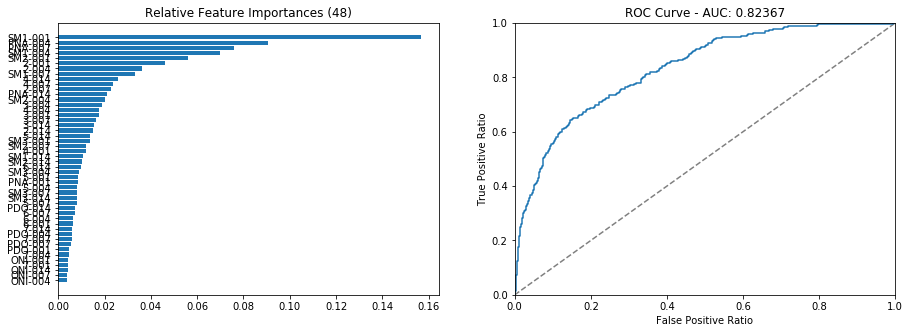

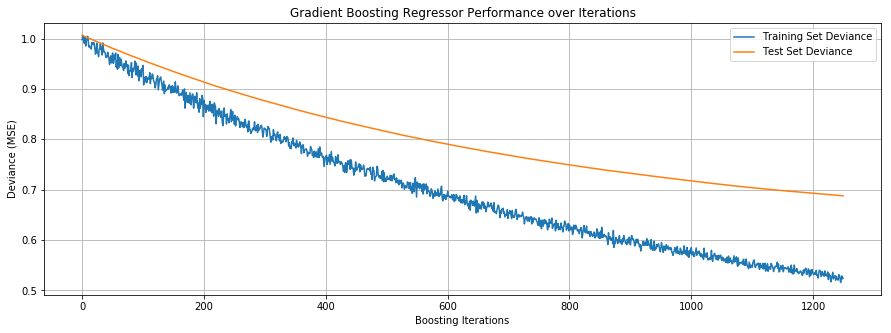

LAG: 2
Spatial Covariance:
 auc  : 0.725 +/- 0.142
Gradient Boosting:
 auc  : 0.788 +/- 0.126

WilcoxonResult(statistic=5.0, pvalue=0.02182427562605354)
Ttest_relResult(statistic=2.179736966033864, pvalue=0.05719899288942442)


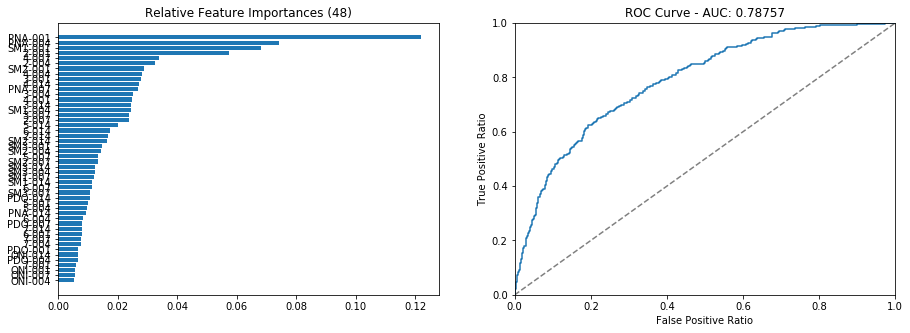

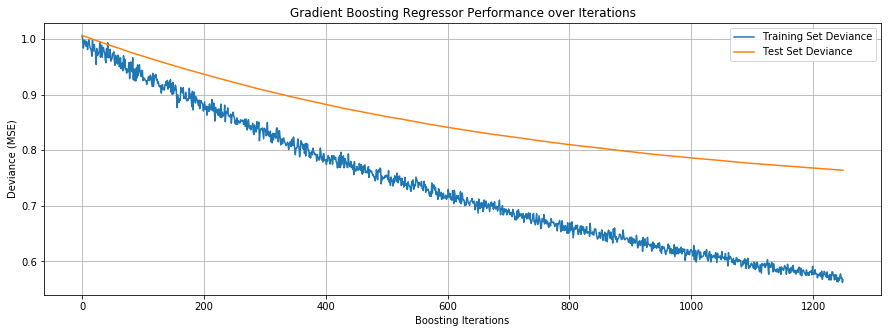

LAG: 4
Spatial Covariance:
 auc  : 0.720 +/- 0.145
Gradient Boosting:
 auc  : 0.718 +/- 0.155

WilcoxonResult(statistic=20.0, pvalue=0.4445867389117455)
Ttest_relResult(statistic=-0.06386320779635733, pvalue=0.9504750948488554)


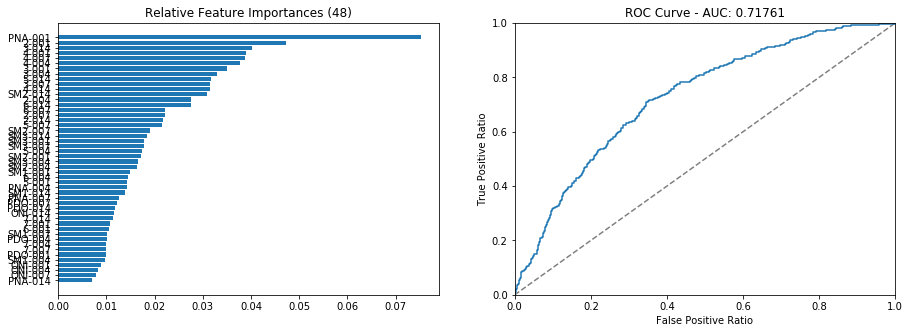

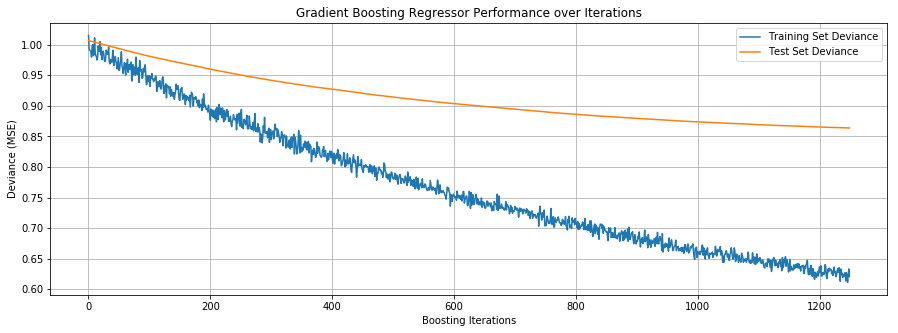

LAG: 6
Spatial Covariance:
 auc  : 0.704 +/- 0.150
Gradient Boosting:
 auc  : 0.668 +/- 0.161

WilcoxonResult(statistic=15.0, pvalue=0.20262160771231197)
Ttest_relResult(statistic=-1.0513382696566391, pvalue=0.3205116301091649)


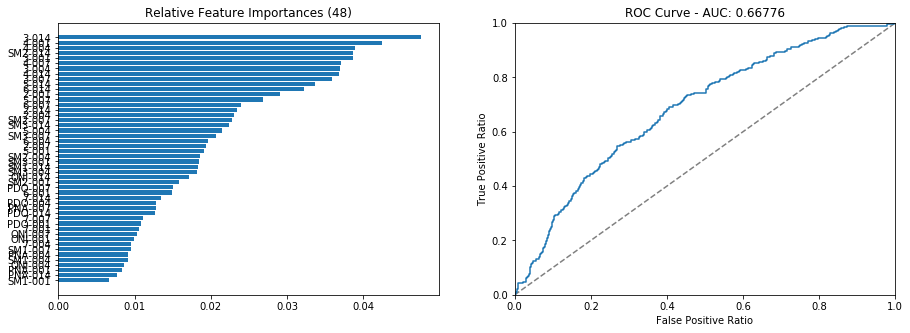

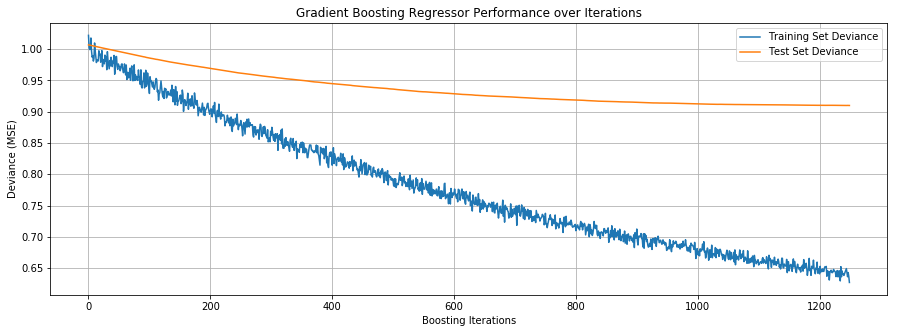

LAG: 8
Spatial Covariance:
 auc  : 0.691 +/- 0.154
Gradient Boosting:
 auc  : 0.660 +/- 0.164

WilcoxonResult(statistic=14.0, pvalue=0.1688069535565081)
Ttest_relResult(statistic=-0.8491484649754721, pvalue=0.4178123340035653)


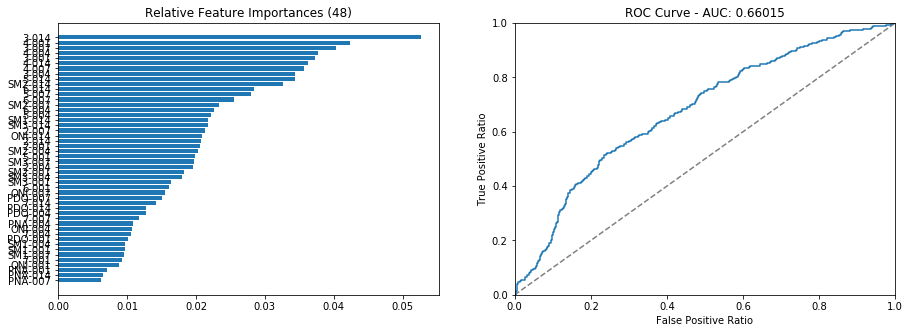

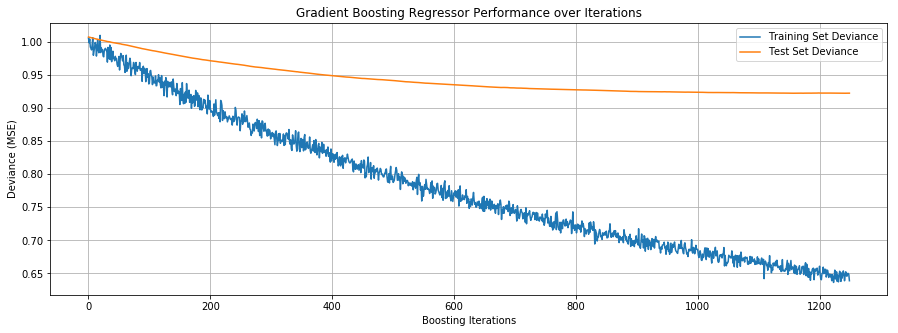

LAG: 10
Spatial Covariance:
 auc  : 0.687 +/- 0.155
Gradient Boosting:
 auc  : 0.658 +/- 0.170

WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)
Ttest_relResult(statistic=-0.6620040509023387, pvalue=0.5245551518536733)


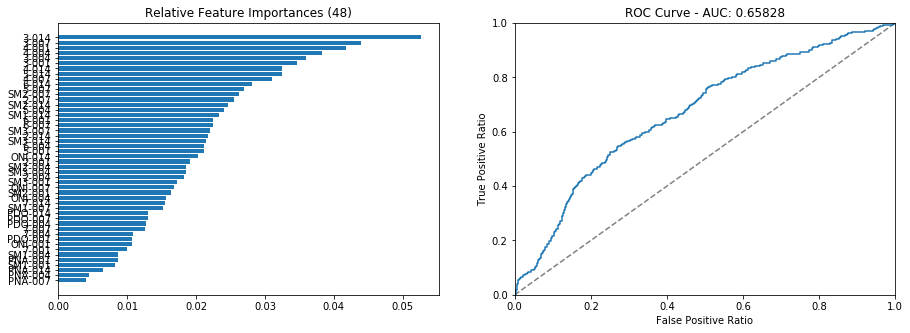

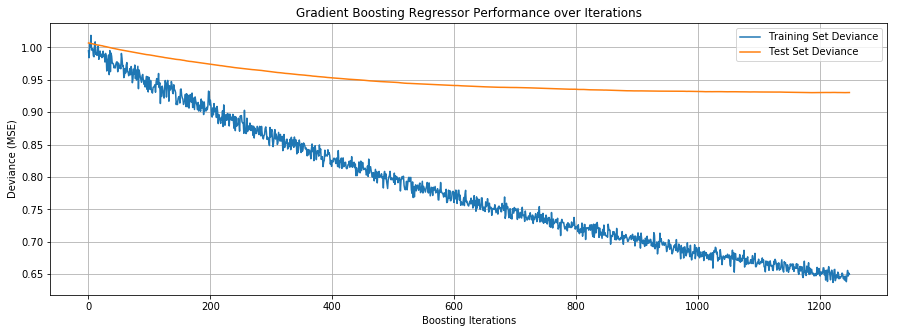

LAG: 12
Spatial Covariance:
 auc  : 0.685 +/- 0.147
Gradient Boosting:
 auc  : 0.641 +/- 0.166

WilcoxonResult(statistic=18.0, pvalue=0.3328797545683888)
Ttest_relResult(statistic=-1.0350526950592858, pvalue=0.3276539151864869)


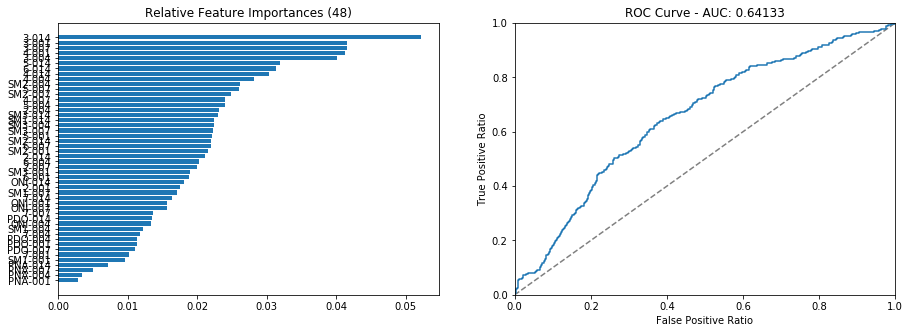

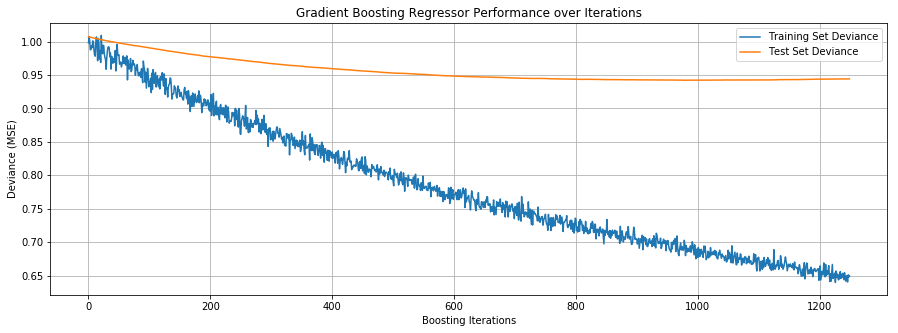

LAG: 14
Spatial Covariance:
 auc  : 0.685 +/- 0.140
Gradient Boosting:
 auc  : 0.633 +/- 0.157

WilcoxonResult(statistic=12.0, pvalue=0.11412832776223863)
Ttest_relResult(statistic=-1.2504881984287246, pvalue=0.2426541563963555)


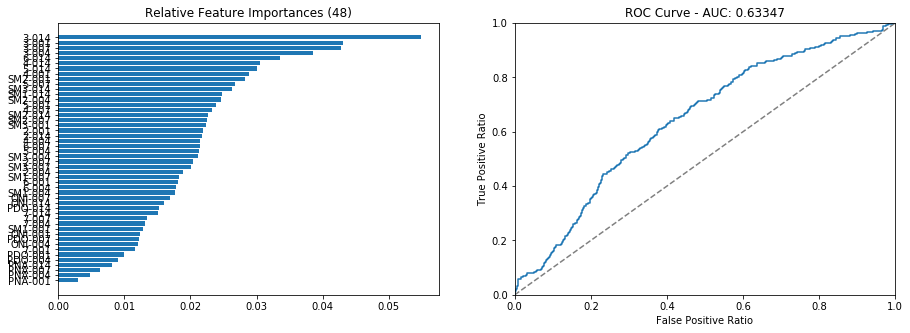

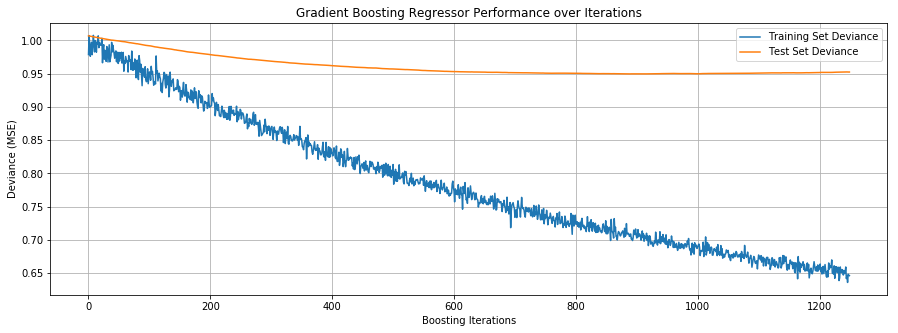

LAG: 16
Spatial Covariance:
 auc  : 0.683 +/- 0.139
Gradient Boosting:
 auc  : 0.640 +/- 0.161

WilcoxonResult(statistic=10.0, pvalue=0.07446183141740546)
Ttest_relResult(statistic=-1.3468531631442962, pvalue=0.21095948631153436)


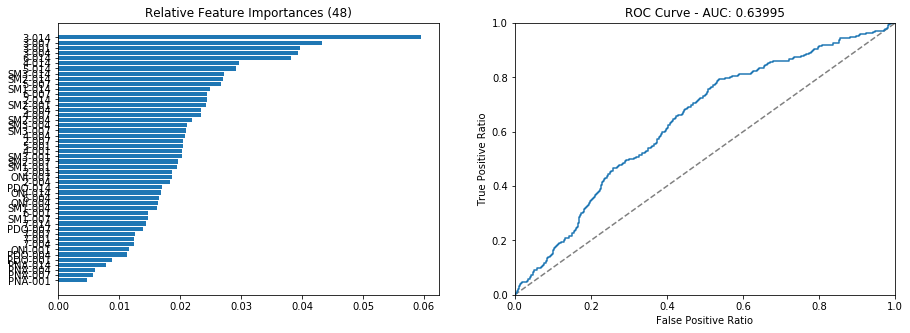

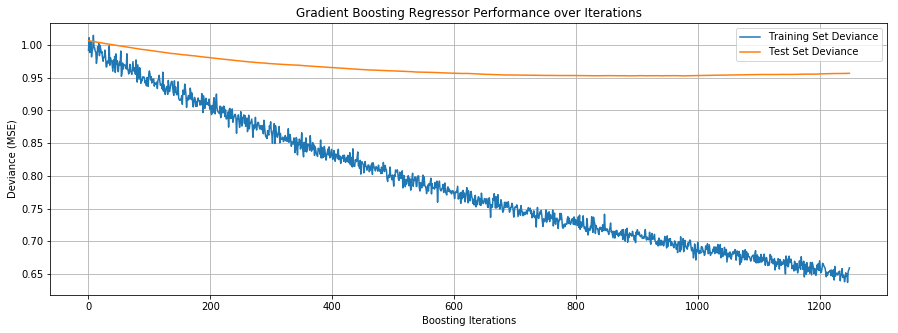

LAG: 18
Spatial Covariance:
 auc  : 0.681 +/- 0.133
Gradient Boosting:
 auc  : 0.651 +/- 0.159

WilcoxonResult(statistic=13.0, pvalue=0.13941397332153205)
Ttest_relResult(statistic=-1.1111148282969712, pvalue=0.2953194197244183)


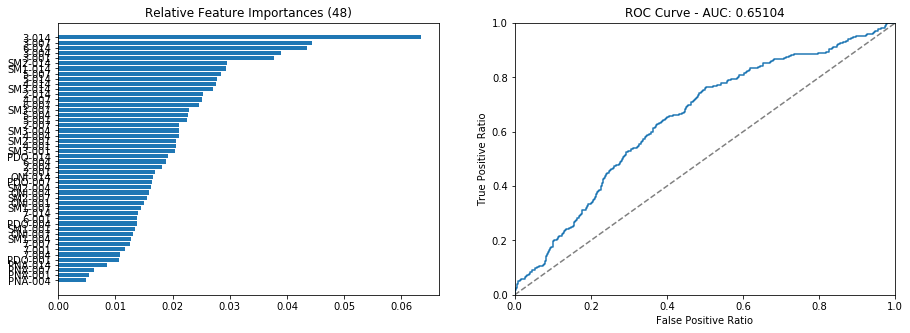

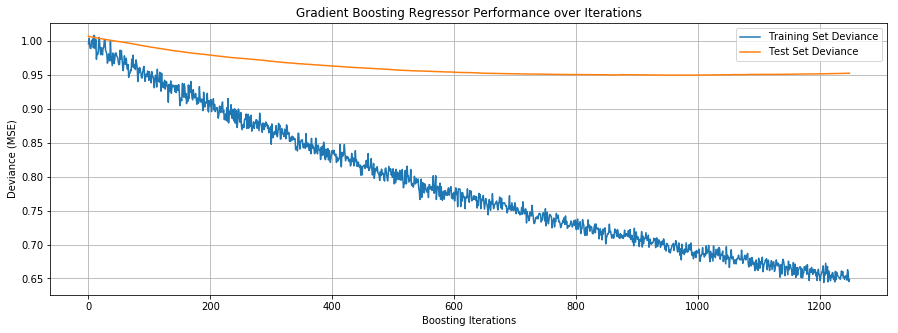

LAG: 20
Spatial Covariance:
 auc  : 0.682 +/- 0.129
Gradient Boosting:
 auc  : 0.672 +/- 0.151

WilcoxonResult(statistic=20.0, pvalue=0.4445867389117455)
Ttest_relResult(statistic=-0.45621654715895693, pvalue=0.6590436471353636)


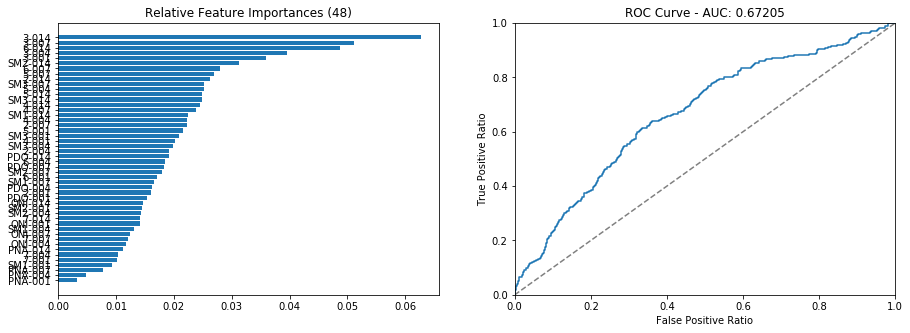

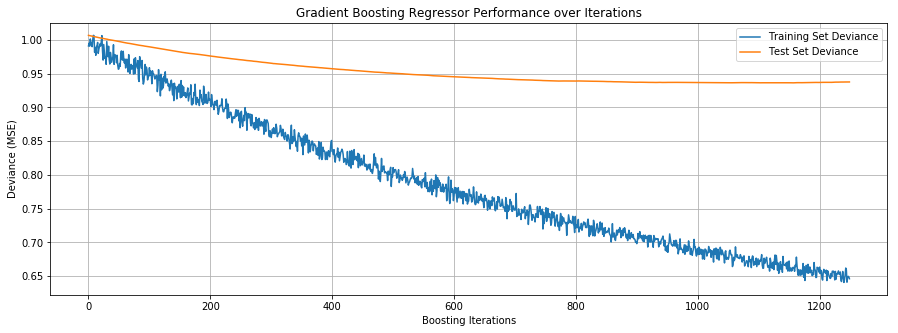

LAG: 22
Spatial Covariance:
 auc  : 0.687 +/- 0.127
Gradient Boosting:
 auc  : 0.677 +/- 0.147

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=-0.7251291580033304, pvalue=0.48679731986933084)


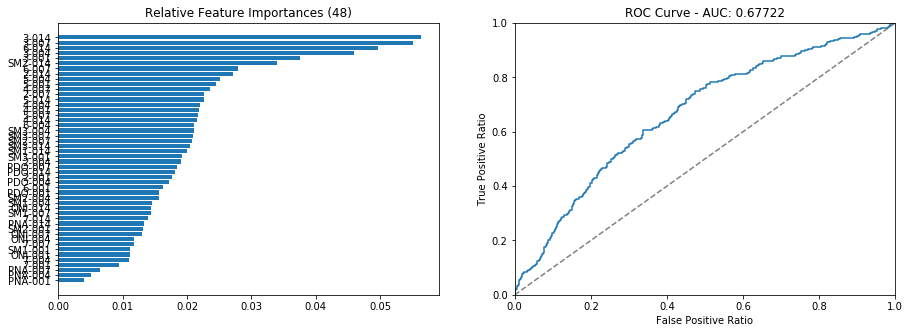

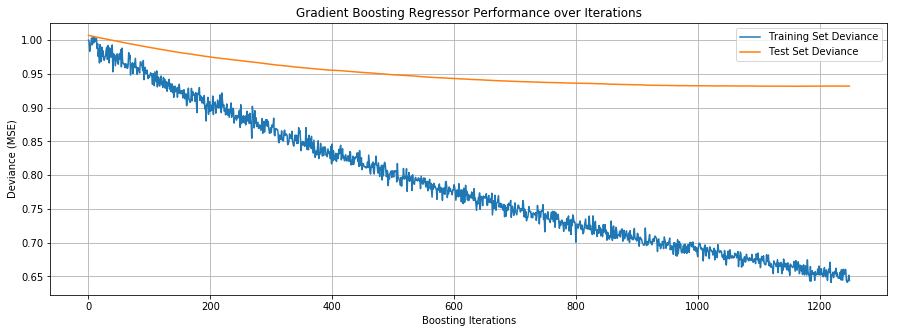

LAG: 24
Spatial Covariance:
 auc  : 0.684 +/- 0.124
Gradient Boosting:
 auc  : 0.683 +/- 0.145

WilcoxonResult(statistic=24.0, pvalue=0.7212766990291557)
Ttest_relResult(statistic=-0.11008981985099565, pvalue=0.9147539056102376)


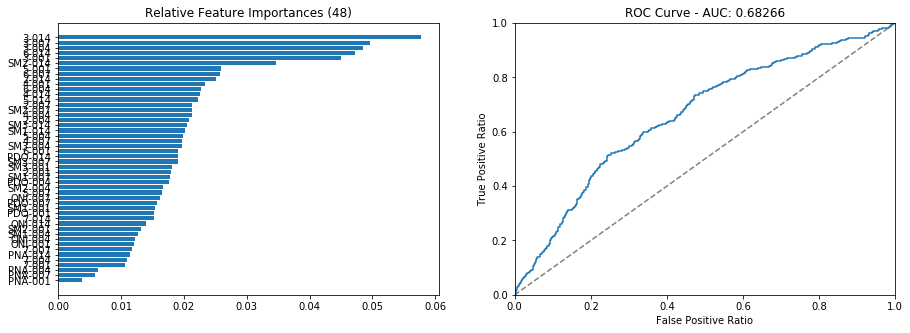

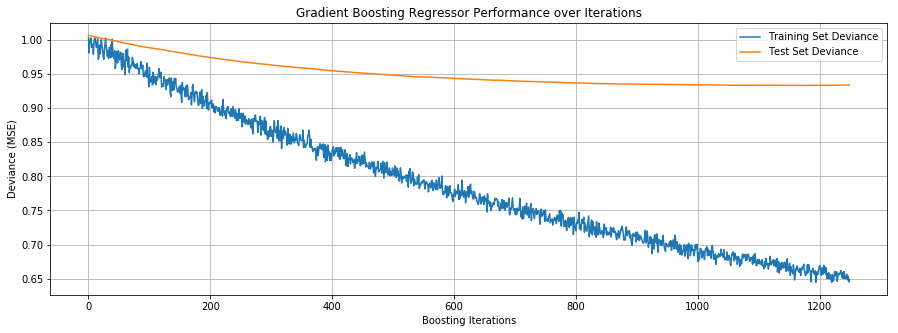

LAG: 26
Spatial Covariance:
 auc  : 0.682 +/- 0.130
Gradient Boosting:
 auc  : 0.688 +/- 0.147

WilcoxonResult(statistic=23.0, pvalue=0.6464622026641696)
Ttest_relResult(statistic=0.24804129236343675, pvalue=0.809669160338066)


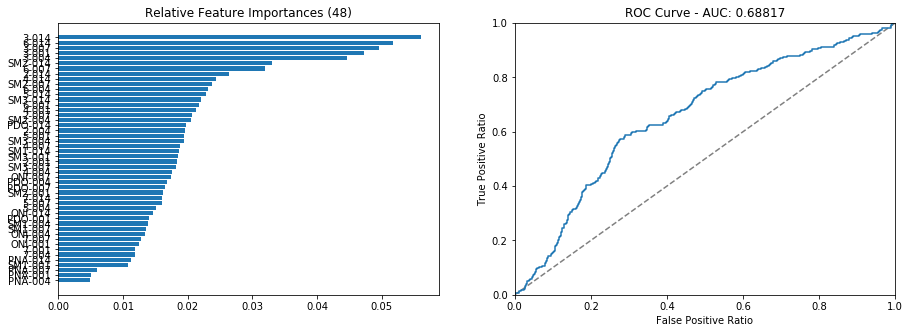

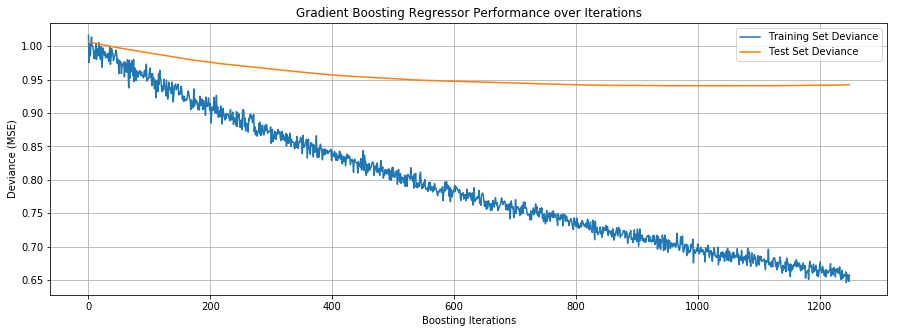

LAG: 28
Spatial Covariance:
 auc  : 0.671 +/- 0.124
Gradient Boosting:
 auc  : 0.690 +/- 0.149

WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
Ttest_relResult(statistic=0.7178769589865152, pvalue=0.4910461436480923)


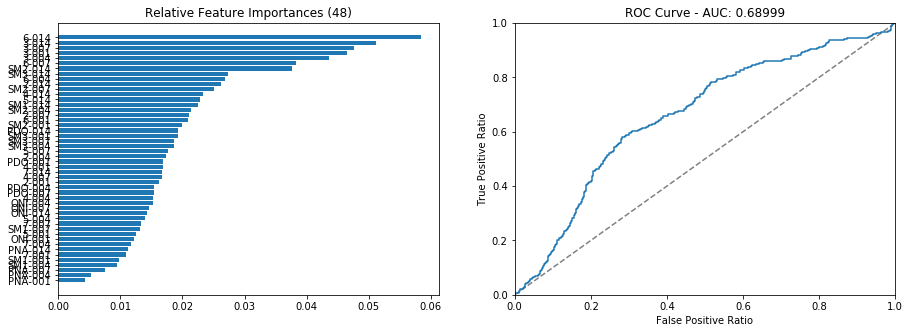

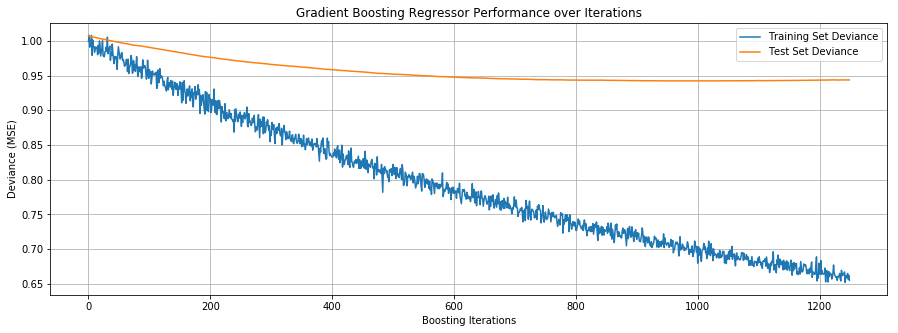

LAG: 30
Spatial Covariance:
 auc  : 0.664 +/- 0.120
Gradient Boosting:
 auc  : 0.691 +/- 0.144

WilcoxonResult(statistic=22.0, pvalue=0.5750621301739497)
Ttest_relResult(statistic=1.0476948165371296, pvalue=0.32209908169511414)


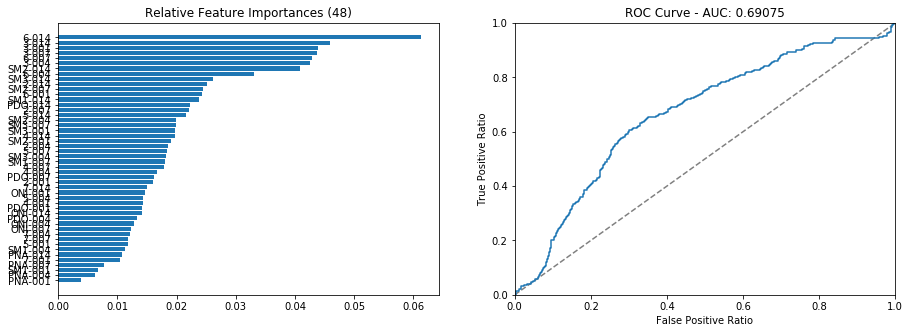

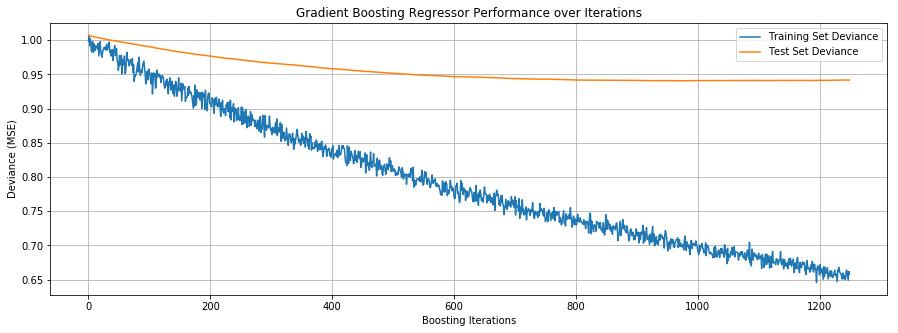

LAG: 32
Spatial Covariance:
 auc  : 0.668 +/- 0.124
Gradient Boosting:
 auc  : 0.691 +/- 0.140

WilcoxonResult(statistic=20.0, pvalue=0.4445867389117455)
Ttest_relResult(statistic=0.8719943216791151, pvalue=0.40587258615517496)


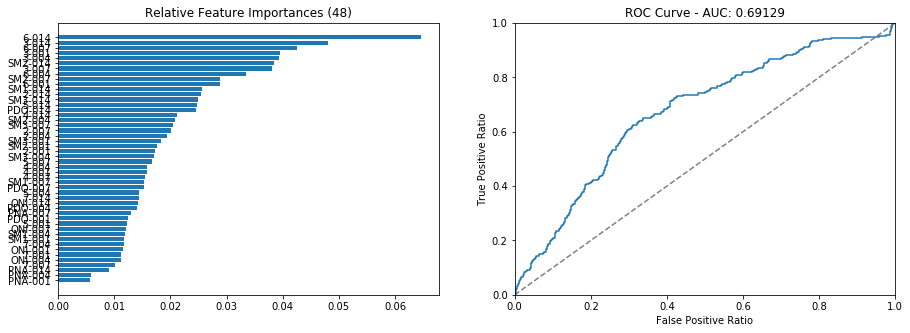

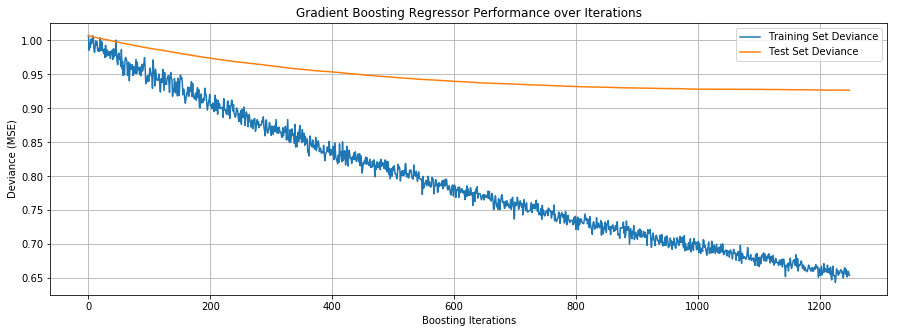

LAG: 34
Spatial Covariance:
 auc  : 0.669 +/- 0.121
Gradient Boosting:
 auc  : 0.686 +/- 0.140

WilcoxonResult(statistic=24.0, pvalue=0.7212766990291557)
Ttest_relResult(statistic=0.6530568823912666, pvalue=0.5300467604699217)


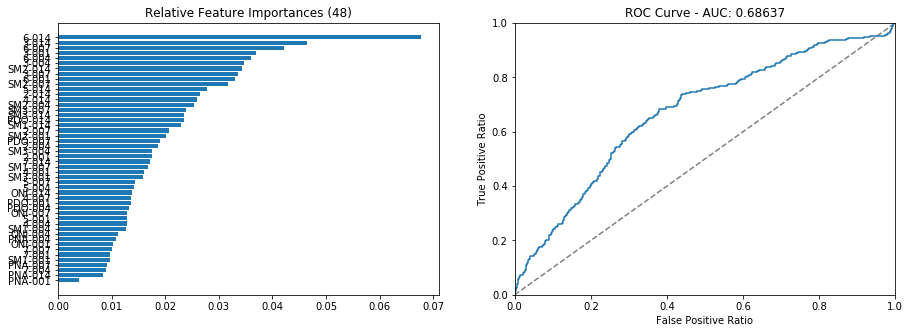

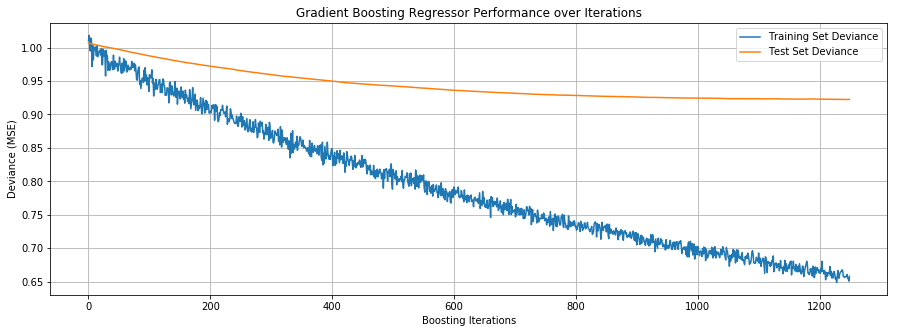

LAG: 36
Spatial Covariance:
 auc  : 0.665 +/- 0.119
Gradient Boosting:
 auc  : 0.682 +/- 0.155

WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
Ttest_relResult(statistic=0.5338765065850692, pvalue=0.6063596475434204)


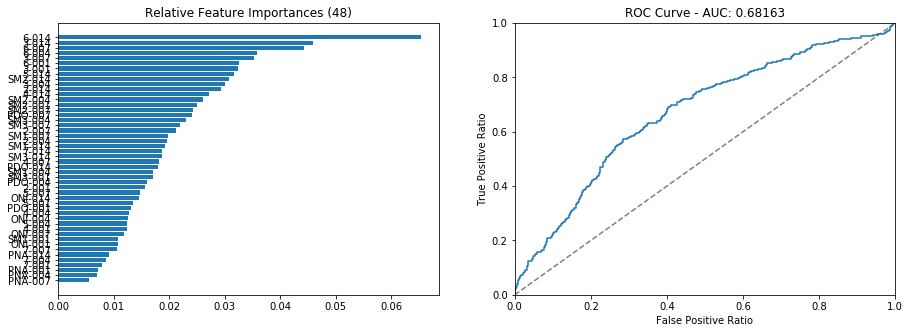

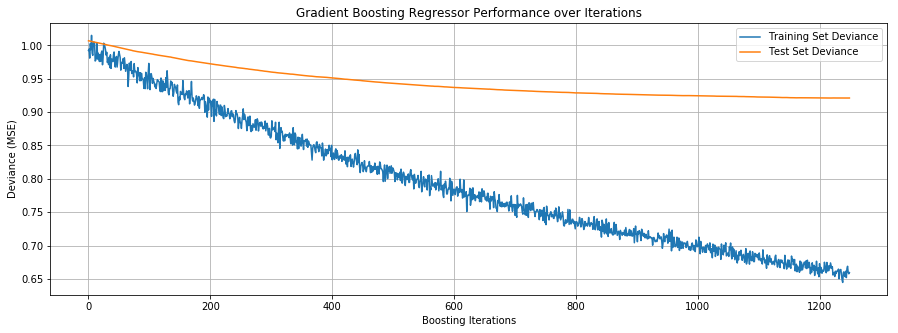

LAG: 38
Spatial Covariance:
 auc  : 0.658 +/- 0.125
Gradient Boosting:
 auc  : 0.681 +/- 0.154

WilcoxonResult(statistic=23.0, pvalue=0.6464622026641696)
Ttest_relResult(statistic=0.738358957625592, pvalue=0.4791067291057012)


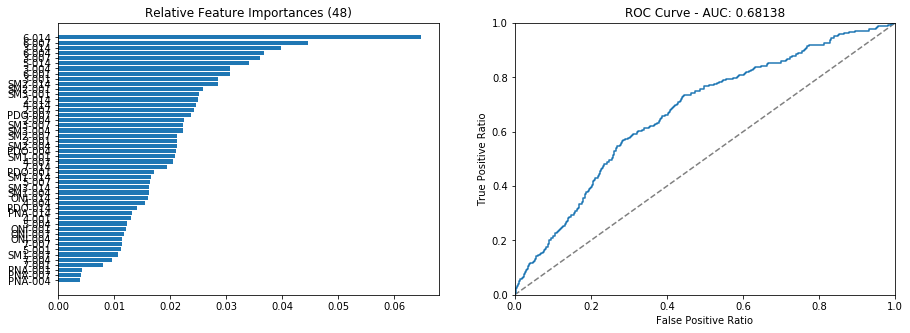

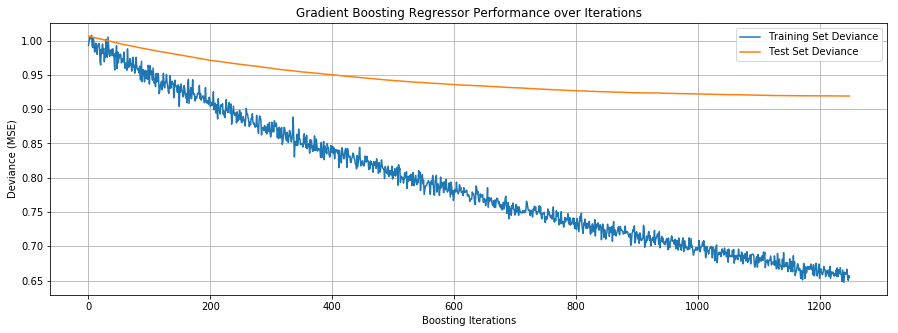

LAG: 40
Spatial Covariance:
 auc  : 0.653 +/- 0.125
Gradient Boosting:
 auc  : 0.691 +/- 0.157

WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)
Ttest_relResult(statistic=1.1536947995055793, pvalue=0.27834188596282494)


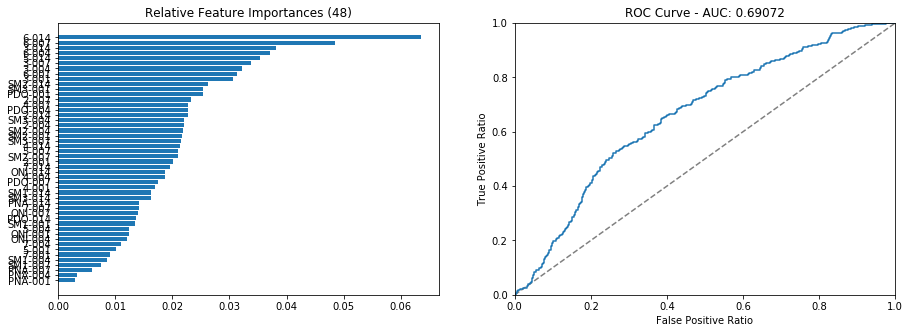

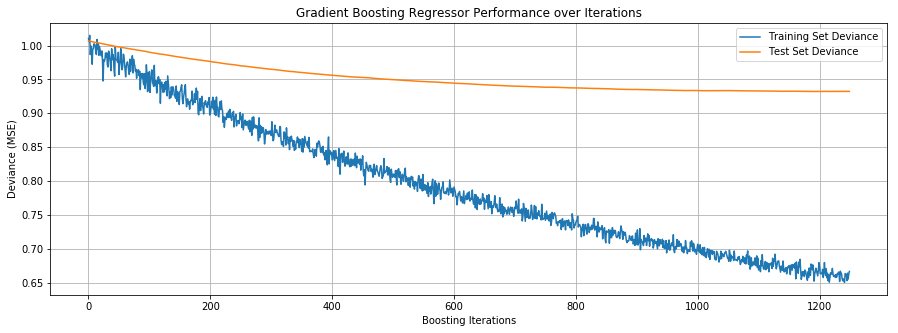

LAG: 42
Spatial Covariance:
 auc  : 0.653 +/- 0.126
Gradient Boosting:
 auc  : 0.699 +/- 0.145

WilcoxonResult(statistic=9.0, pvalue=0.05933611988090862)
Ttest_relResult(statistic=1.6289550418780019, pvalue=0.1377627159167959)


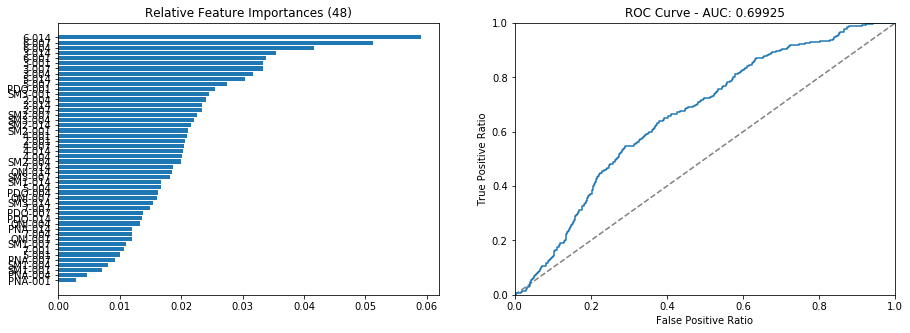

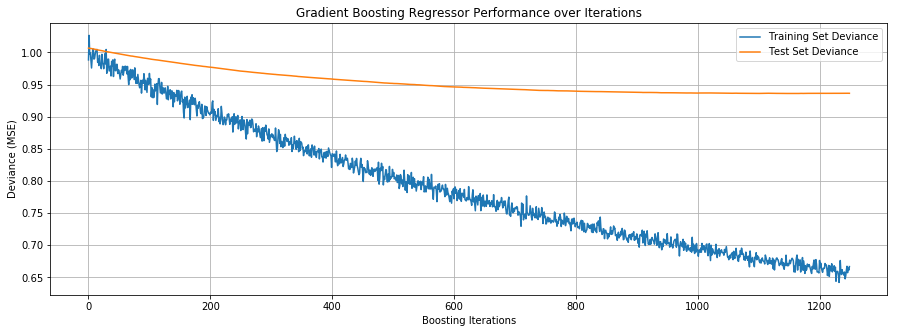

LAG: 44
Spatial Covariance:
 auc  : 0.656 +/- 0.131
Gradient Boosting:
 auc  : 0.710 +/- 0.125

WilcoxonResult(statistic=11.0, pvalue=0.09260069782067576)
Ttest_relResult(statistic=1.905214906574462, pvalue=0.08914150505522224)


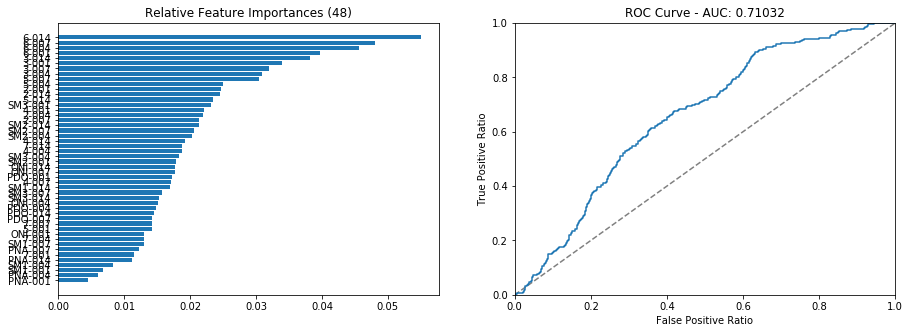

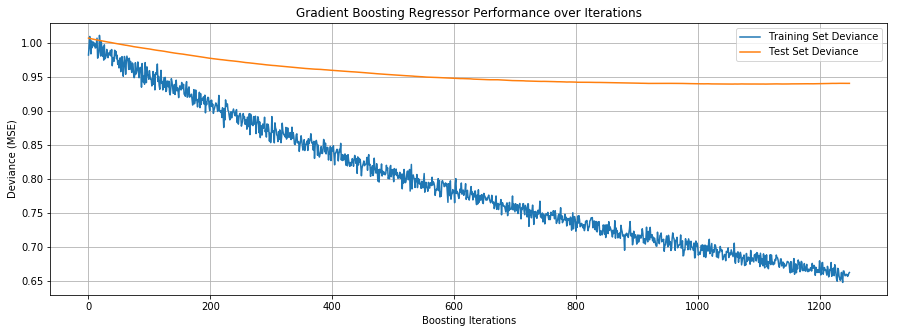

LAG: 46
Spatial Covariance:
 auc  : 0.659 +/- 0.131
Gradient Boosting:
 auc  : 0.708 +/- 0.124

WilcoxonResult(statistic=15.0, pvalue=0.20262160771231197)
Ttest_relResult(statistic=1.4744423916757352, pvalue=0.1744616391665303)


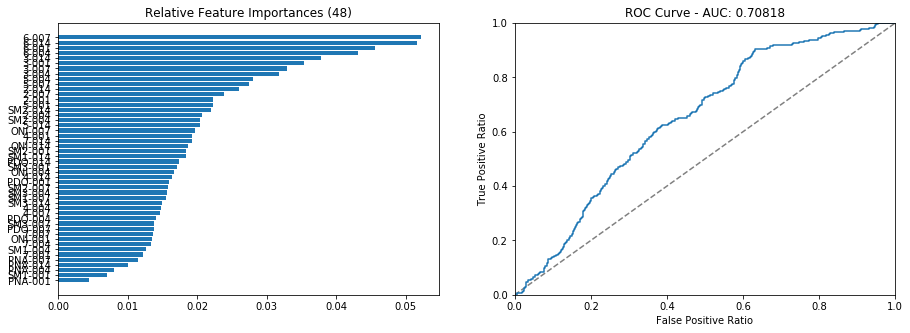

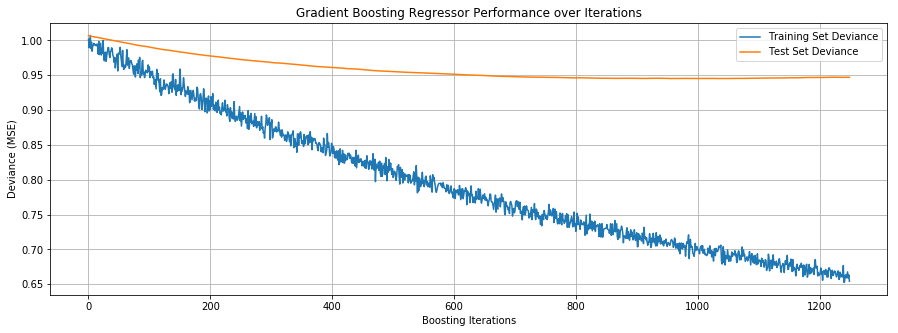

LAG: 48
Spatial Covariance:
 auc  : 0.655 +/- 0.131
Gradient Boosting:
 auc  : 0.696 +/- 0.125

WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)
Ttest_relResult(statistic=1.0980561414279857, pvalue=0.300686480297563)


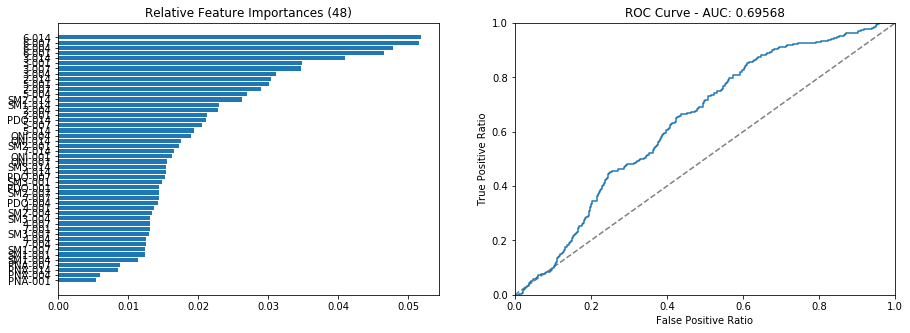

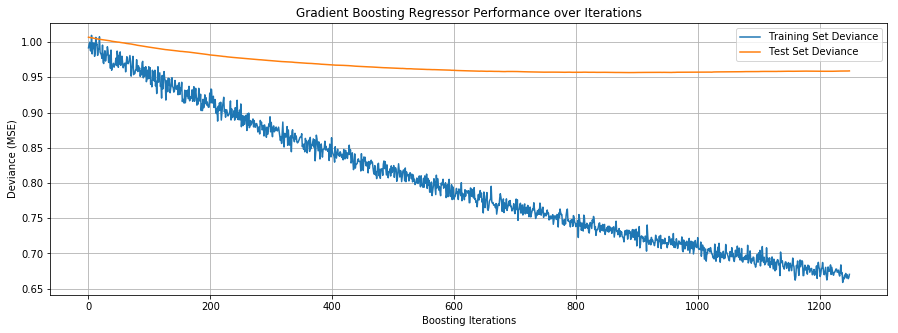

LAG: 50
Spatial Covariance:
 auc  : 0.649 +/- 0.139
Gradient Boosting:
 auc  : 0.689 +/- 0.133

WilcoxonResult(statistic=23.0, pvalue=0.6464622026641696)
Ttest_relResult(statistic=1.0064304679724274, pvalue=0.3404990310953404)


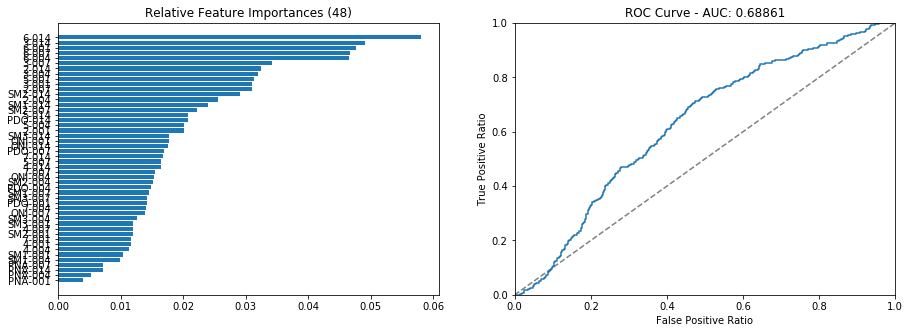

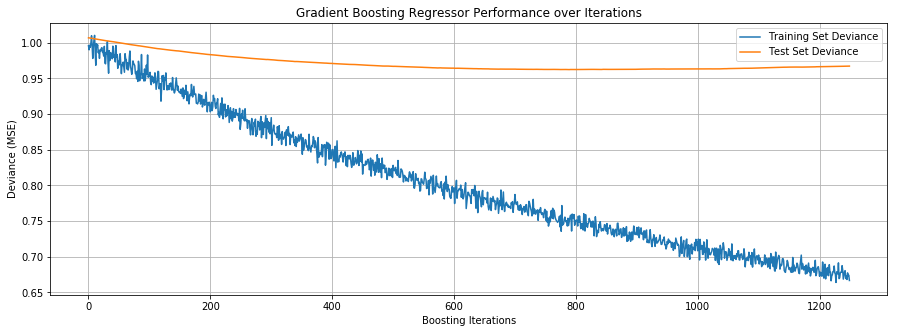

LAG: 52
Spatial Covariance:
 auc  : 0.639 +/- 0.144
Gradient Boosting:
 auc  : 0.678 +/- 0.143

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=1.0321597002552052, pvalue=0.32893527555894336)


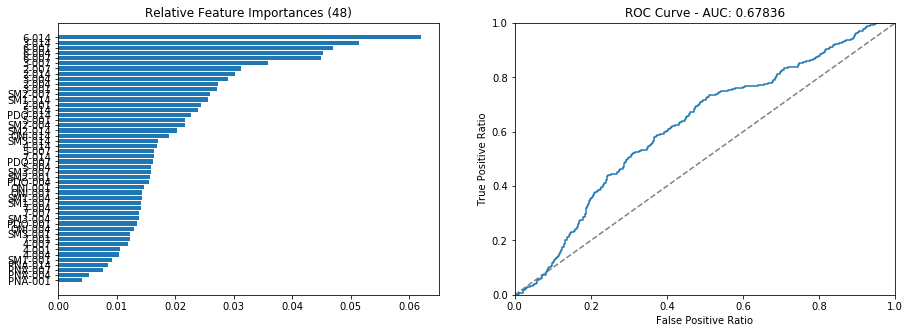

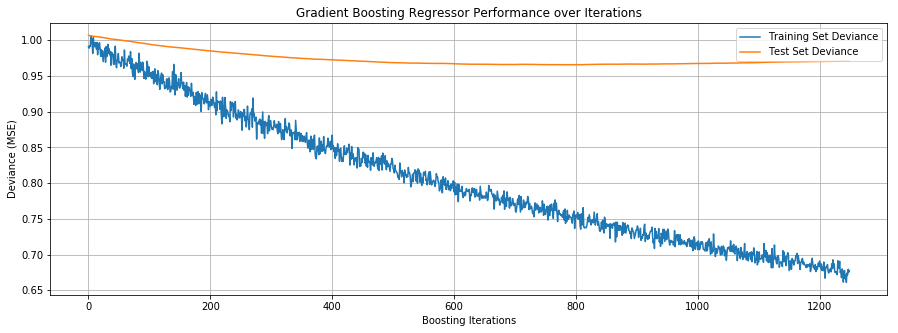

LAG: 54
Spatial Covariance:
 auc  : 0.636 +/- 0.152
Gradient Boosting:
 auc  : 0.668 +/- 0.150

WilcoxonResult(statistic=24.0, pvalue=0.7212766990291557)
Ttest_relResult(statistic=0.8570302541628863, pvalue=0.4136659122343962)


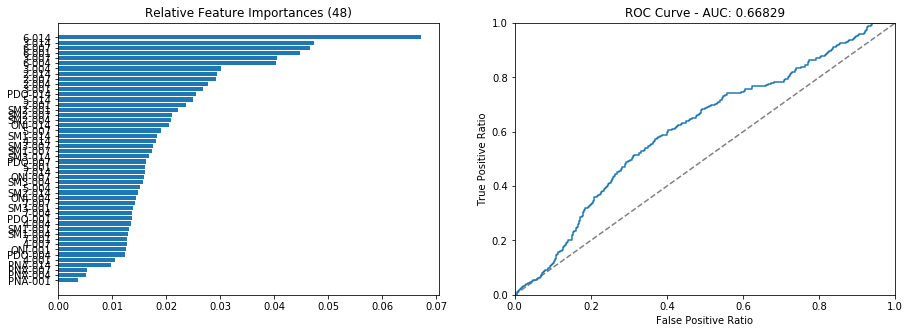

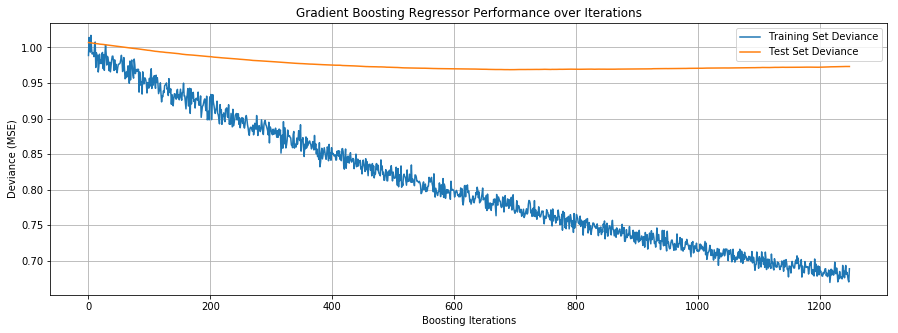

LAG: 56
Spatial Covariance:
 auc  : 0.639 +/- 0.149
Gradient Boosting:
 auc  : 0.662 +/- 0.147

WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)
Ttest_relResult(statistic=0.6025949859782644, pvalue=0.5616521786779614)


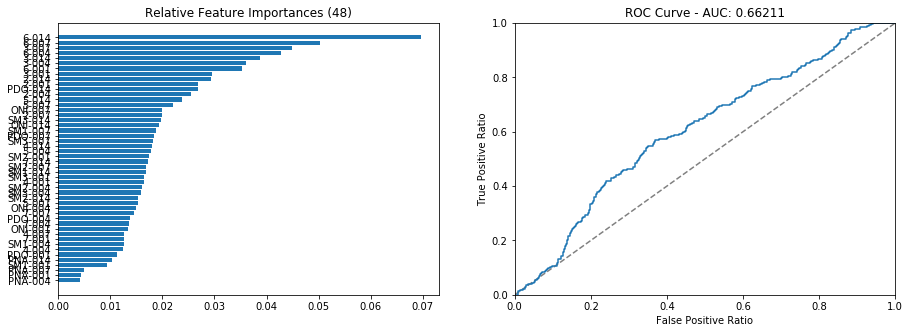

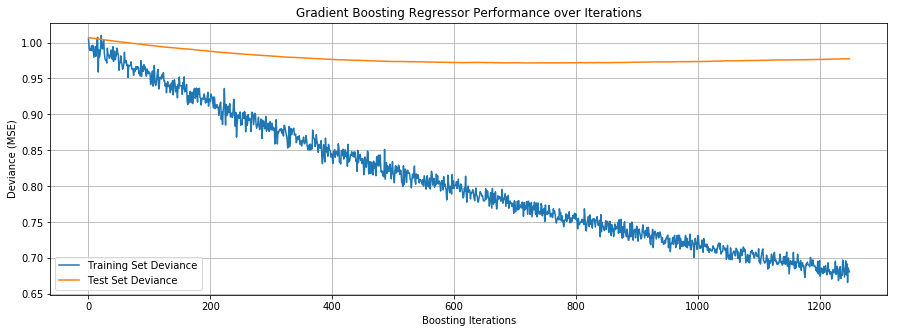

LAG: 58
Spatial Covariance:
 auc  : 0.645 +/- 0.147
Gradient Boosting:
 auc  : 0.657 +/- 0.148

WilcoxonResult(statistic=25.0, pvalue=0.7988593499960496)
Ttest_relResult(statistic=0.30451758799280954, pvalue=0.767657397335457)


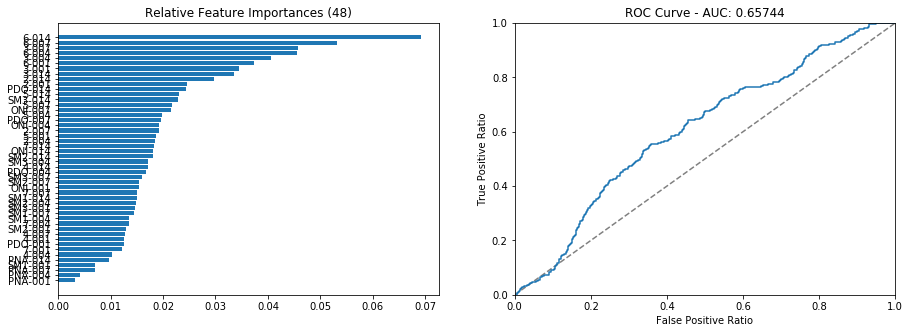

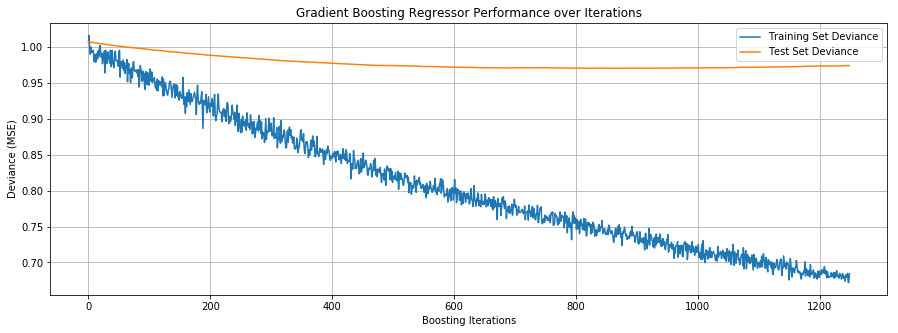

LAG: 60
Spatial Covariance:
 auc  : 0.646 +/- 0.148
Gradient Boosting:
 auc  : 0.668 +/- 0.151

WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
Ttest_relResult(statistic=0.5108368179384782, pvalue=0.6217594643469149)


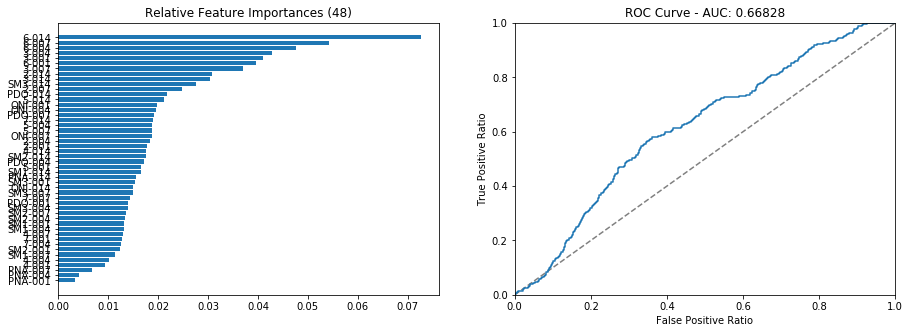

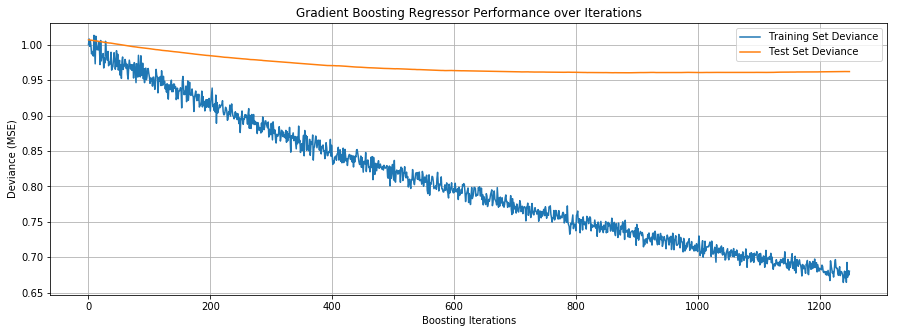

LAG: 62
Spatial Covariance:
 auc  : 0.644 +/- 0.147
Gradient Boosting:
 auc  : 0.672 +/- 0.153

WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
Ttest_relResult(statistic=0.6269428836814844, pvalue=0.5462695180797508)


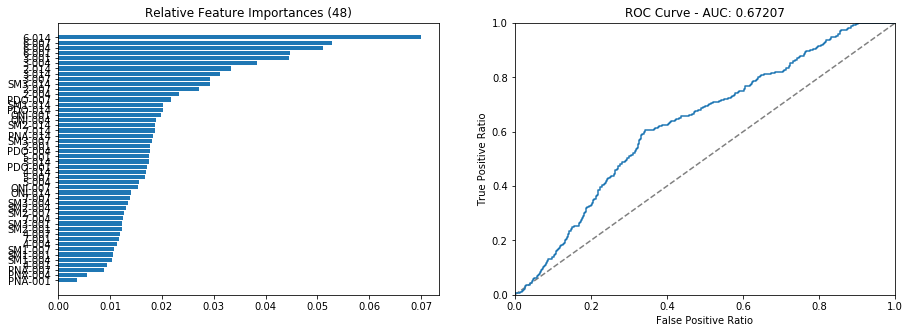

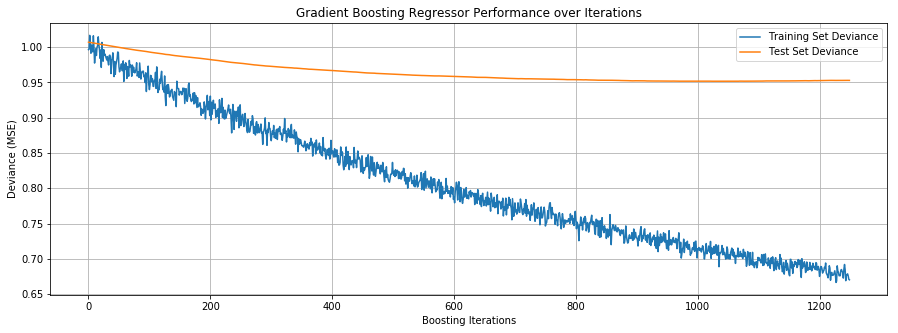

LAG: 64
Spatial Covariance:
 auc  : 0.640 +/- 0.146
Gradient Boosting:
 auc  : 0.678 +/- 0.155

WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)
Ttest_relResult(statistic=0.8692119516774008, pvalue=0.407313822849244)


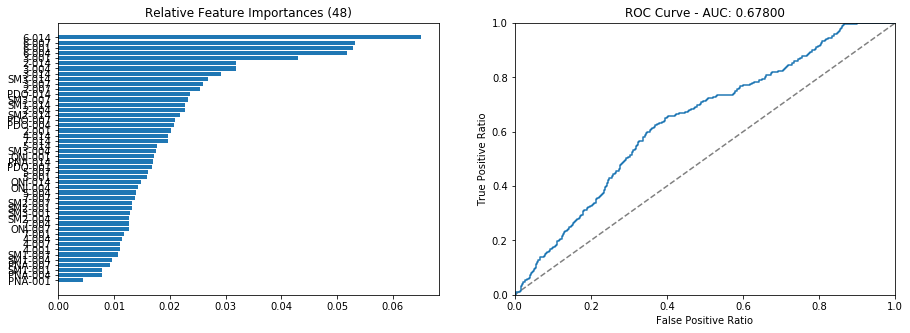

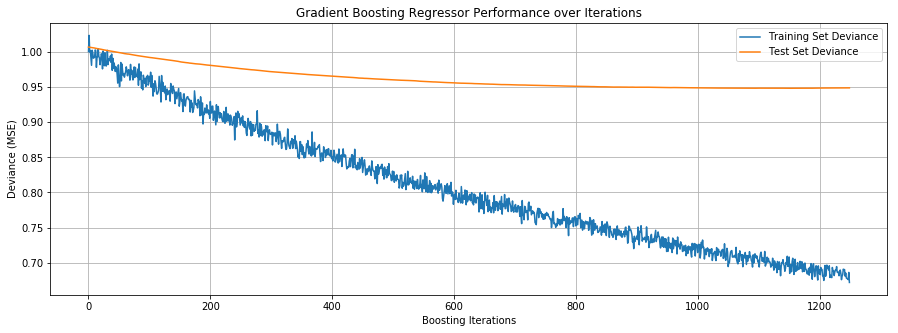

LAG: 66
Spatial Covariance:
 auc  : 0.637 +/- 0.147
Gradient Boosting:
 auc  : 0.669 +/- 0.150

WilcoxonResult(statistic=25.0, pvalue=0.7988593499960496)
Ttest_relResult(statistic=0.7035814456275553, pvalue=0.4994895951154522)


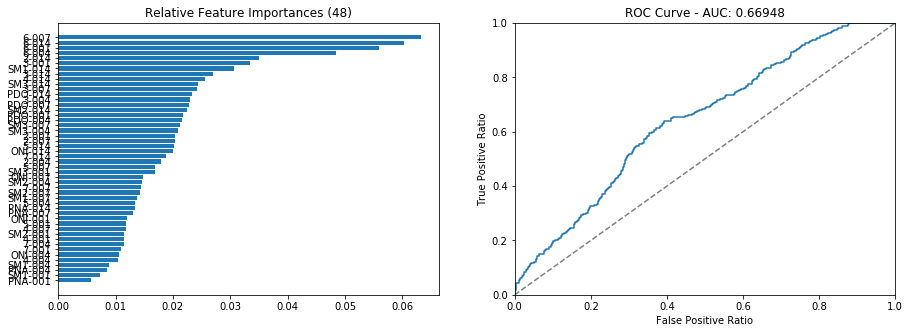

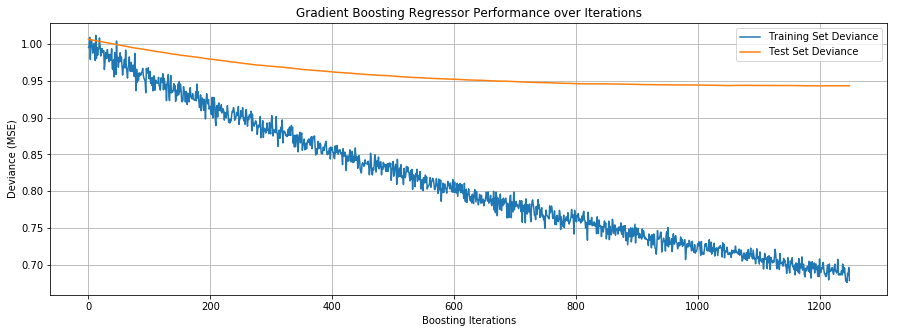

LAG: 68
Spatial Covariance:
 auc  : 0.630 +/- 0.150
Gradient Boosting:
 auc  : 0.654 +/- 0.144

WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)
Ttest_relResult(statistic=0.467591345330928, pvalue=0.6511919033671831)


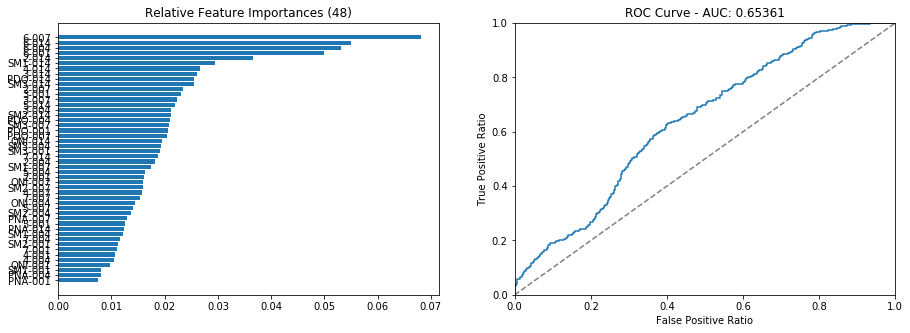

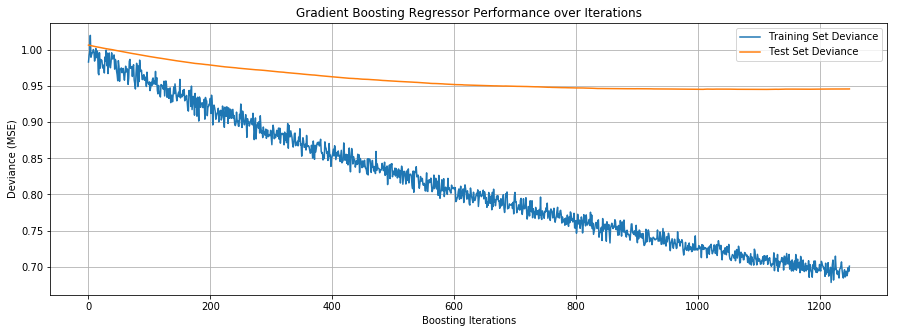

LAG: 70
Spatial Covariance:
 auc  : 0.620 +/- 0.157
Gradient Boosting:
 auc  : 0.650 +/- 0.130

WilcoxonResult(statistic=23.0, pvalue=0.6464622026641696)
Ttest_relResult(statistic=0.5809265525852373, pvalue=0.5755464509729814)


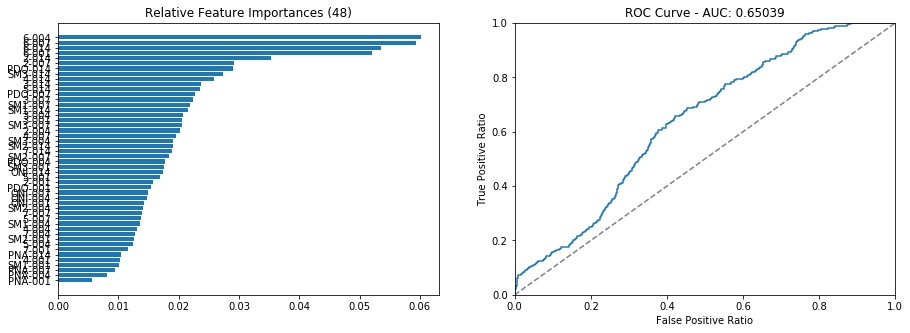

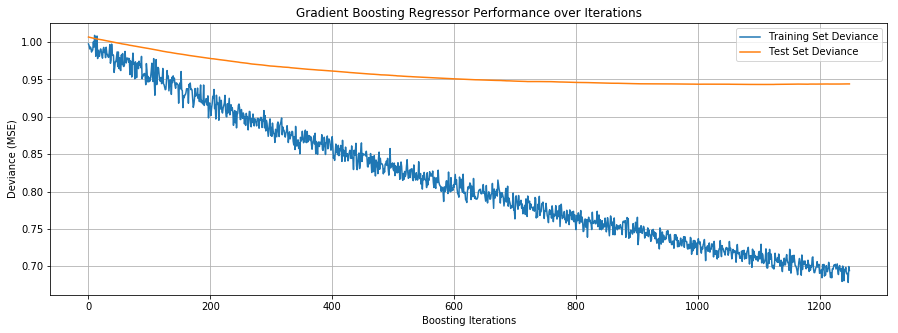

LAG: 72
Spatial Covariance:
 auc  : 0.615 +/- 0.161
Gradient Boosting:
 auc  : 0.643 +/- 0.130

WilcoxonResult(statistic=22.0, pvalue=0.5750621301739497)
Ttest_relResult(statistic=0.5514379282364531, pvalue=0.5947573355925843)


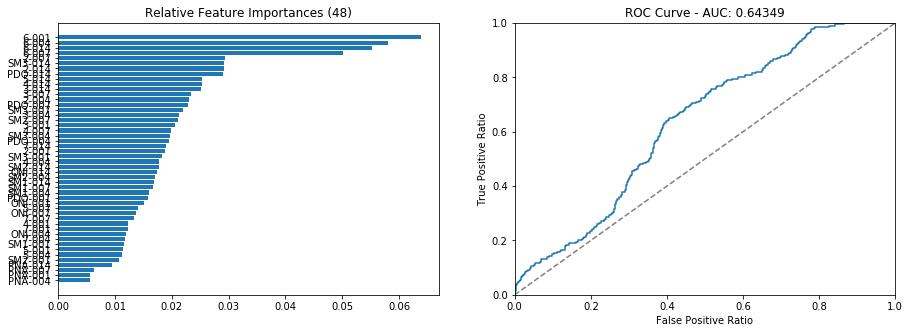

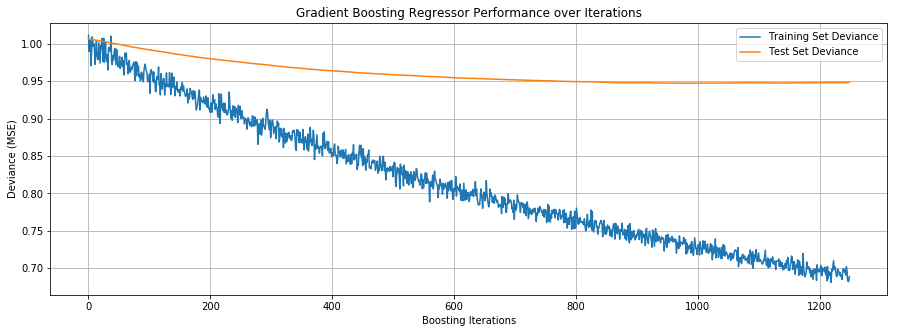

LAG: 74
Spatial Covariance:
 auc  : 0.610 +/- 0.158
Gradient Boosting:
 auc  : 0.647 +/- 0.128

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=0.7711601426397094, pvalue=0.46037775137645587)


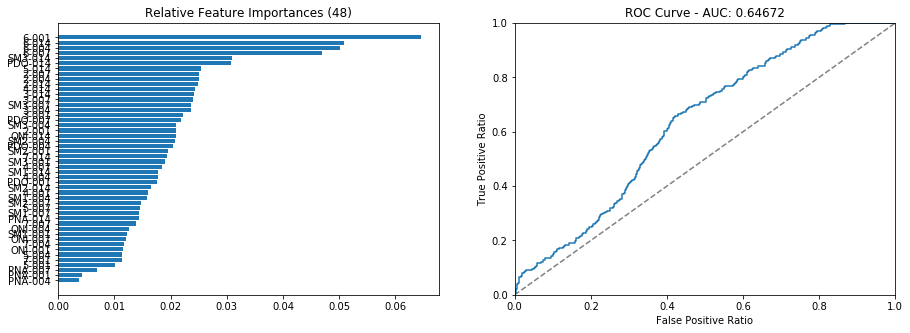

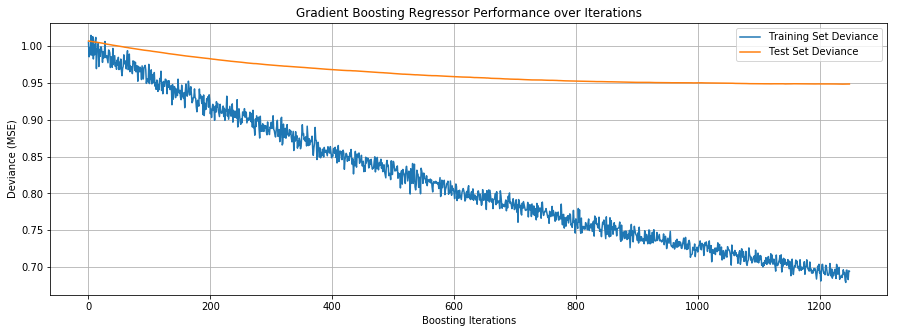

LAG: 76
Spatial Covariance:
 auc  : 0.608 +/- 0.150
Gradient Boosting:
 auc  : 0.634 +/- 0.121

WilcoxonResult(statistic=22.0, pvalue=0.5750621301739497)
Ttest_relResult(statistic=0.5600345356065758, pvalue=0.5891214639227371)


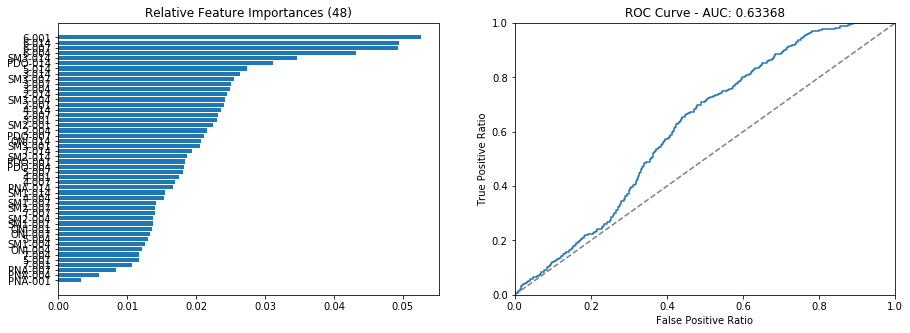

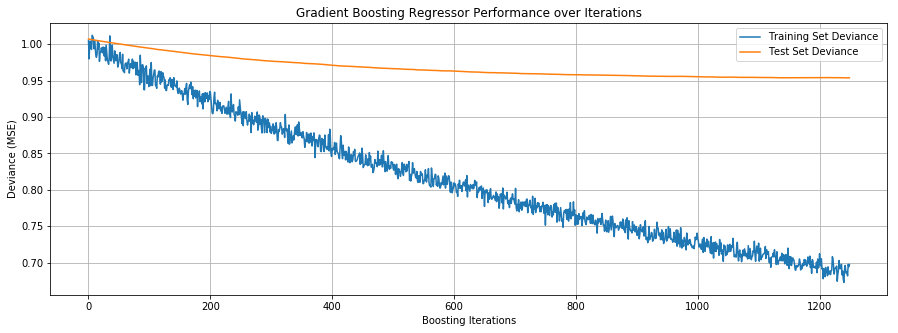

LAG: 78
Spatial Covariance:
 auc  : 0.603 +/- 0.144
Gradient Boosting:
 auc  : 0.631 +/- 0.112

WilcoxonResult(statistic=22.0, pvalue=0.5750621301739497)
Ttest_relResult(statistic=0.5707492905217936, pvalue=0.5821376596455365)


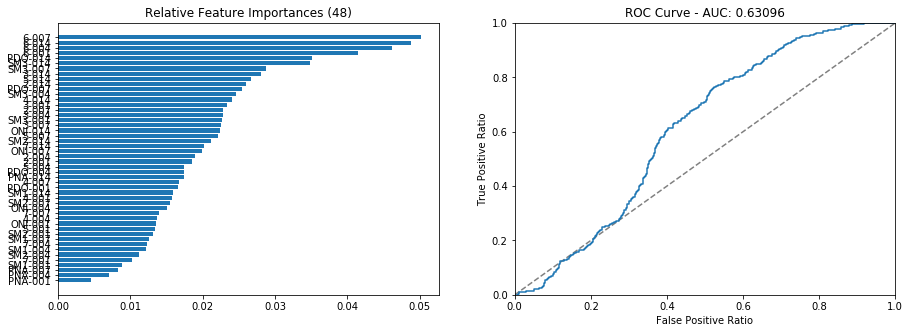

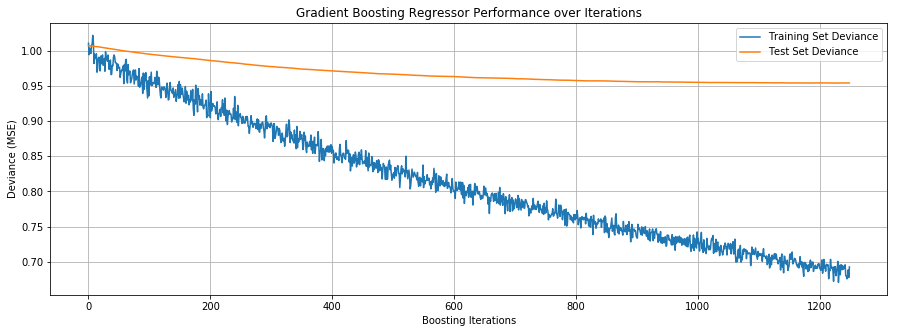

LAG: 80
Spatial Covariance:
 auc  : 0.599 +/- 0.143
Gradient Boosting:
 auc  : 0.646 +/- 0.115

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=0.880257550255674, pvalue=0.40161342132623856)


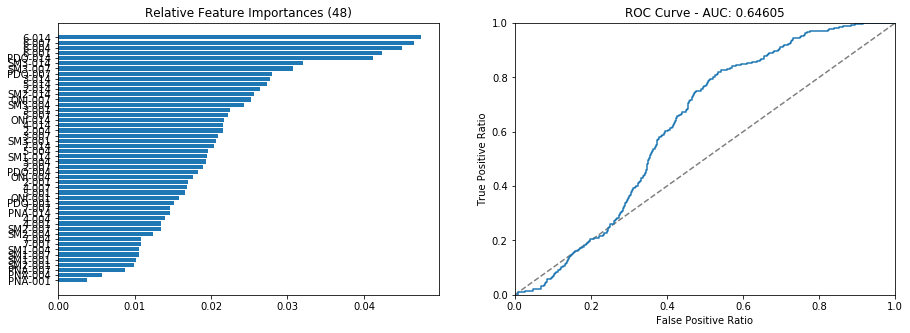

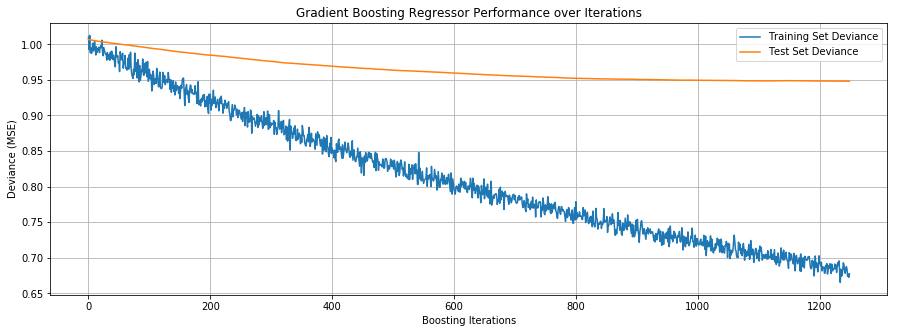

LAG: 82
Spatial Covariance:
 auc  : 0.597 +/- 0.140
Gradient Boosting:
 auc  : 0.659 +/- 0.122

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=1.073140140009541, pvalue=0.31113782338660484)


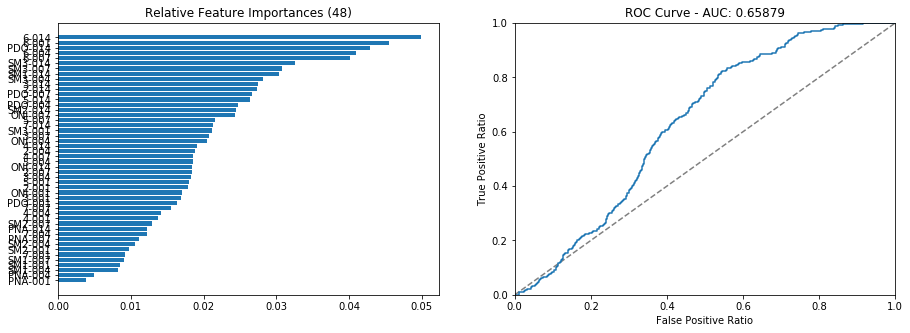

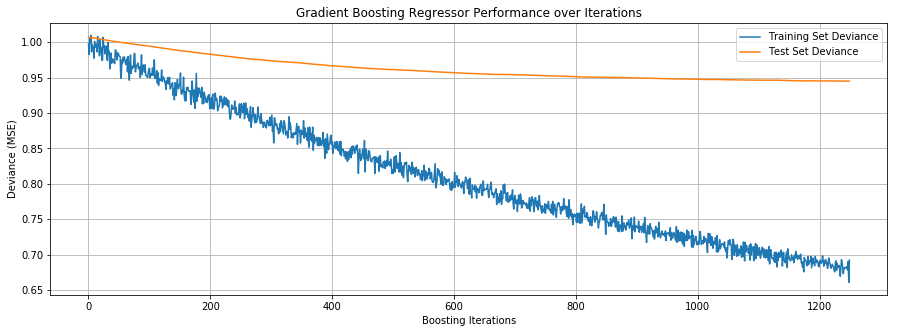

LAG: 84
Spatial Covariance:
 auc  : 0.603 +/- 0.131
Gradient Boosting:
 auc  : 0.657 +/- 0.115

WilcoxonResult(statistic=20.0, pvalue=0.4445867389117455)
Ttest_relResult(statistic=0.9257575557566721, pvalue=0.37872690739035775)


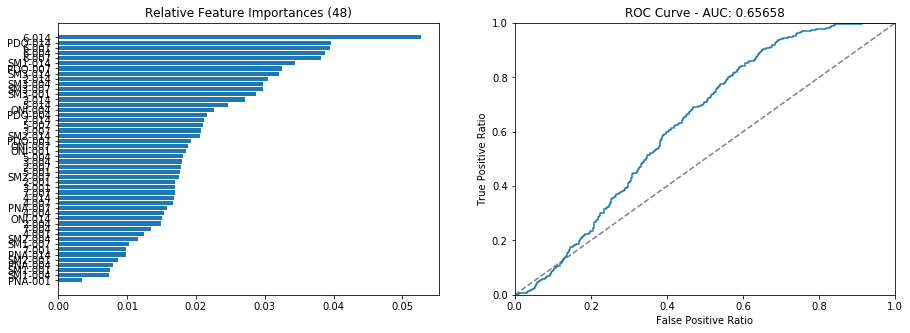

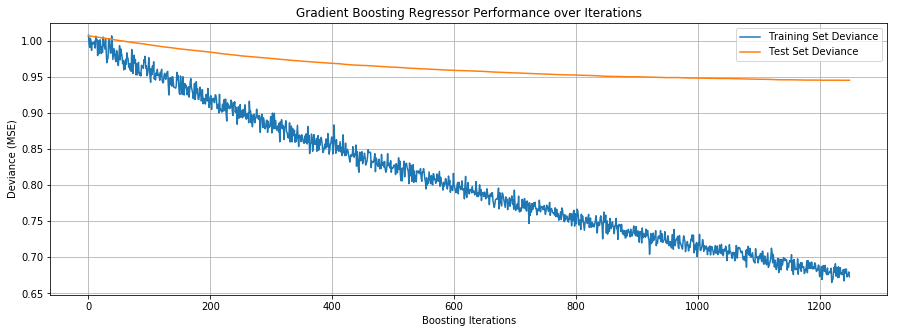

LAG: 86
Spatial Covariance:
 auc  : 0.609 +/- 0.130
Gradient Boosting:
 auc  : 0.656 +/- 0.121

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=0.8439186080681285, pvalue=0.42057944903097777)


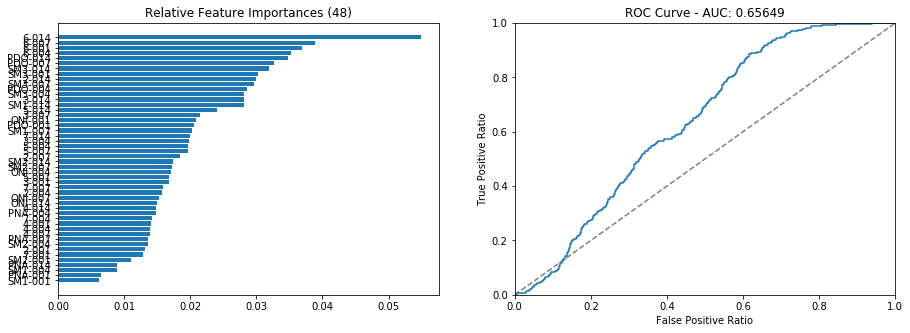

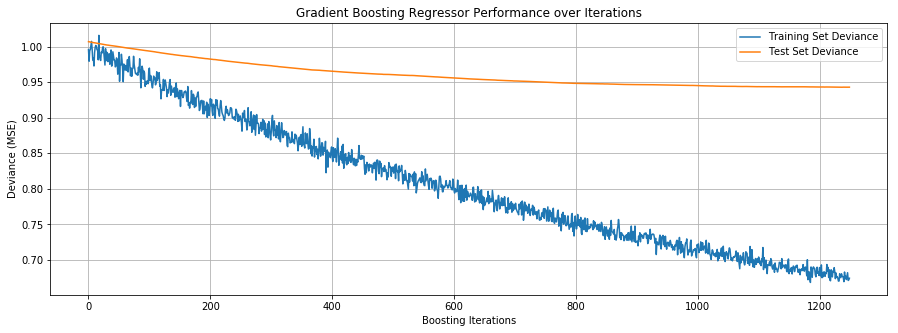

LAG: 88
Spatial Covariance:
 auc  : 0.610 +/- 0.127
Gradient Boosting:
 auc  : 0.644 +/- 0.141

WilcoxonResult(statistic=25.0, pvalue=0.7988593499960496)
Ttest_relResult(statistic=0.552017813576147, pvalue=0.5943762585793816)


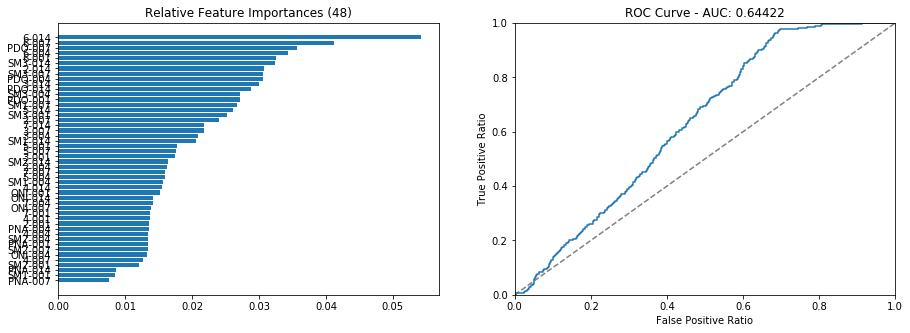

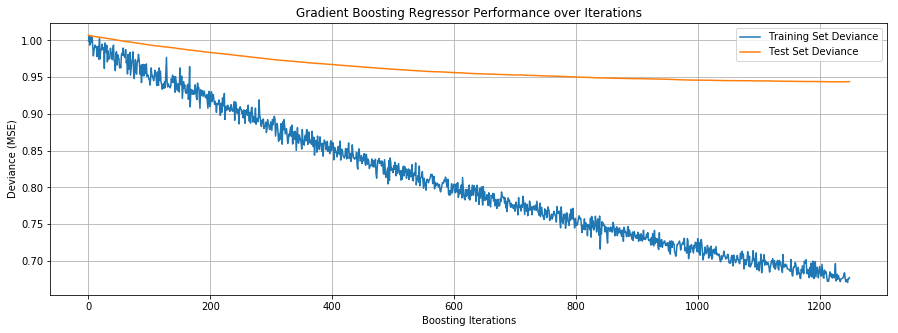

LAG: 90
Spatial Covariance:
 auc  : 0.614 +/- 0.135
Gradient Boosting:
 auc  : 0.631 +/- 0.136

WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)
Ttest_relResult(statistic=0.26452266830345217, pvalue=0.7973352774372217)


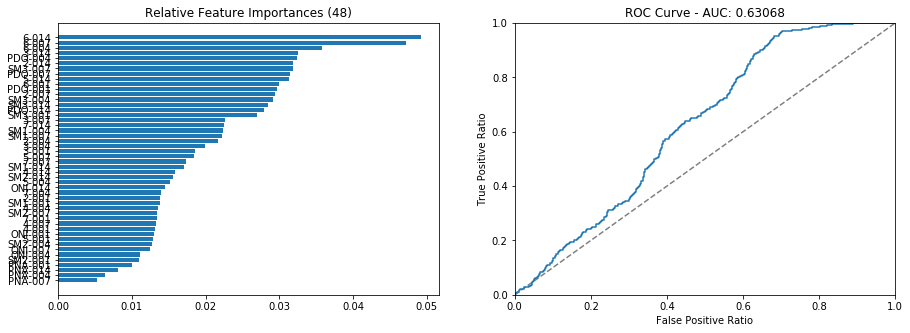

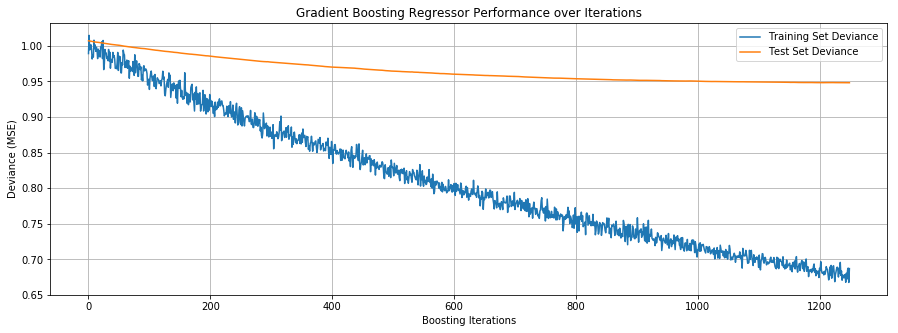

LAG: 92
Spatial Covariance:
 auc  : 0.616 +/- 0.150
Gradient Boosting:
 auc  : 0.625 +/- 0.109

WilcoxonResult(statistic=27.0, pvalue=0.9593536340401635)
Ttest_relResult(statistic=0.16636971391086572, pvalue=0.8715436462275186)


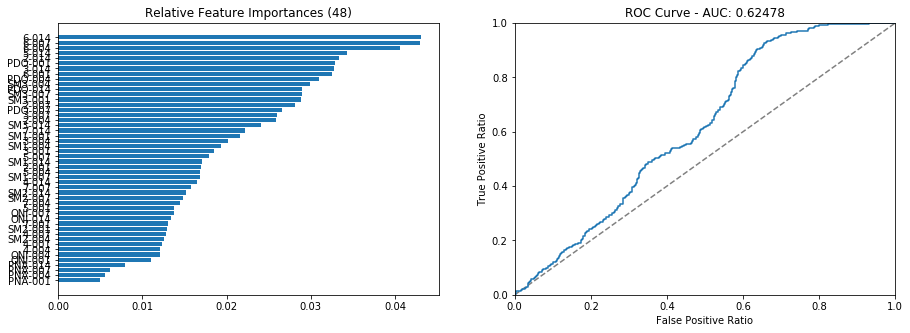

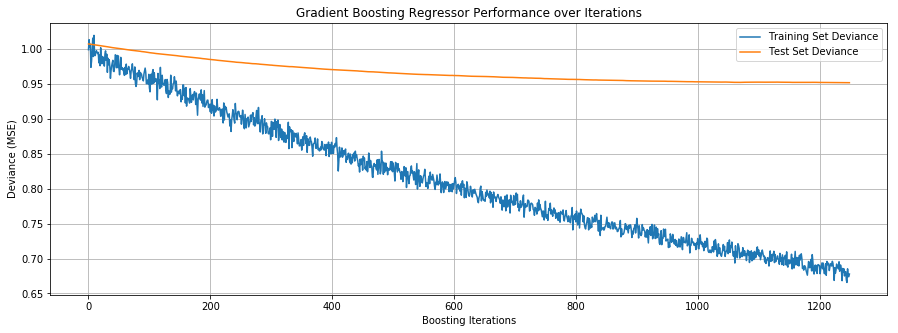

LAG: 94
Spatial Covariance:
 auc  : 0.625 +/- 0.154
Gradient Boosting:
 auc  : 0.601 +/- 0.110

WilcoxonResult(statistic=21.0, pvalue=0.5076243443095237)
Ttest_relResult(statistic=-0.44967583527016075, pvalue=0.663578685615768)


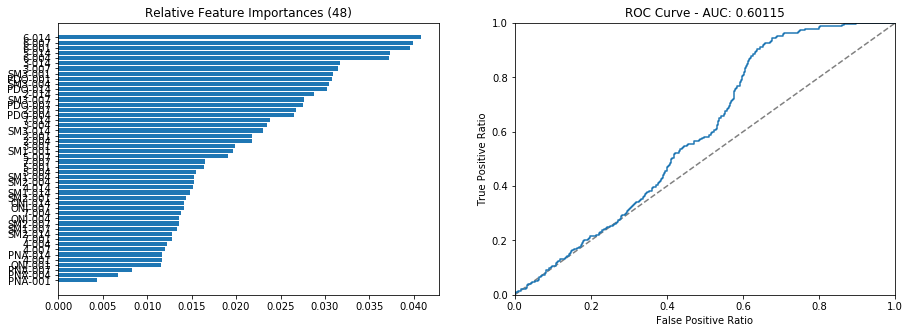

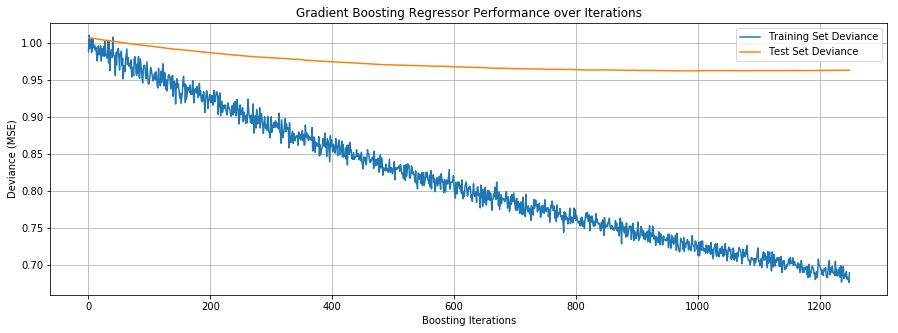

LAG: 96
Spatial Covariance:
 auc  : 0.629 +/- 0.150
Gradient Boosting:
 auc  : 0.574 +/- 0.107

WilcoxonResult(statistic=19.0, pvalue=0.3862707203664827)
Ttest_relResult(statistic=-1.0029015602651954, pvalue=0.34210865156293074)


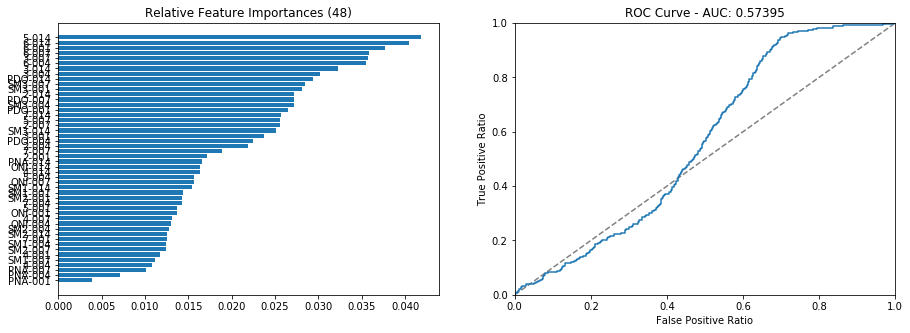

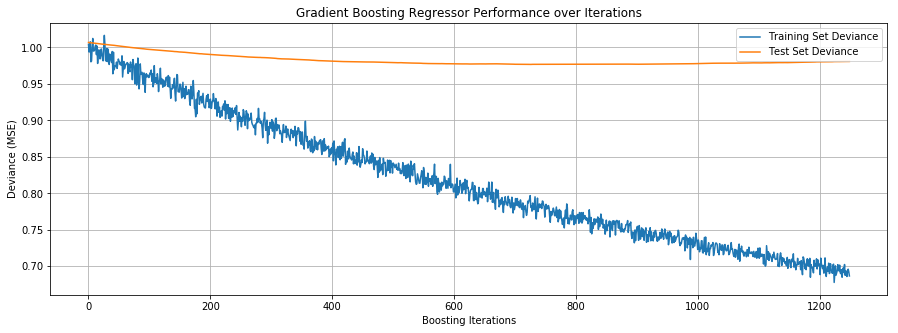

LAG: 98
Spatial Covariance:
 auc  : 0.633 +/- 0.144
Gradient Boosting:
 auc  : 0.559 +/- 0.105

WilcoxonResult(statistic=16.0, pvalue=0.24112136827741826)
Ttest_relResult(statistic=-1.2791478858064478, pvalue=0.23283859728056616)


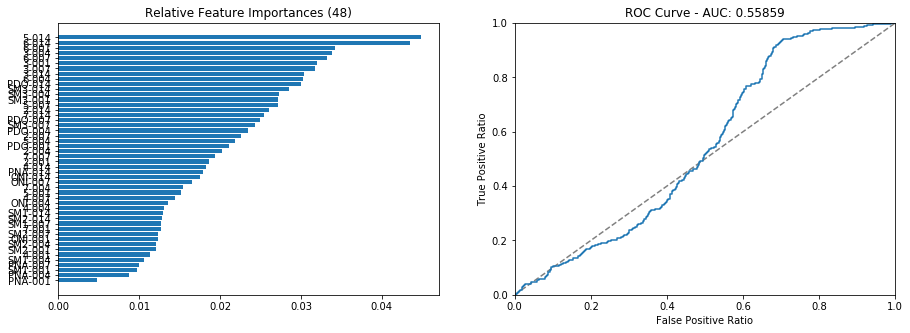

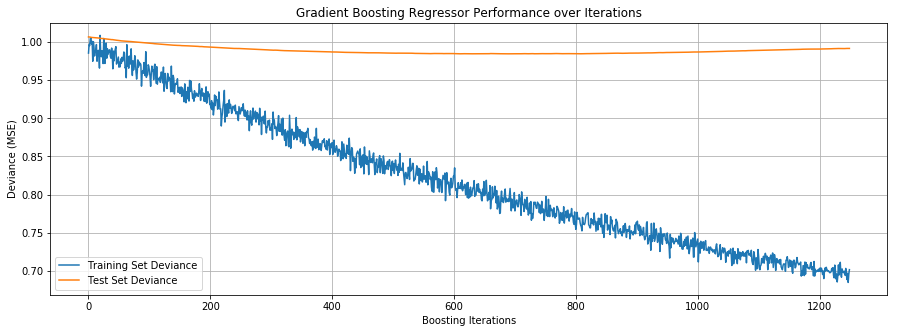

LAG: 100
Spatial Covariance:
 auc  : 0.637 +/- 0.139
Gradient Boosting:
 auc  : 0.559 +/- 0.102

WilcoxonResult(statistic=14.0, pvalue=0.1688069535565081)
Ttest_relResult(statistic=-1.555590018948604, pvalue=0.15422879323585087)


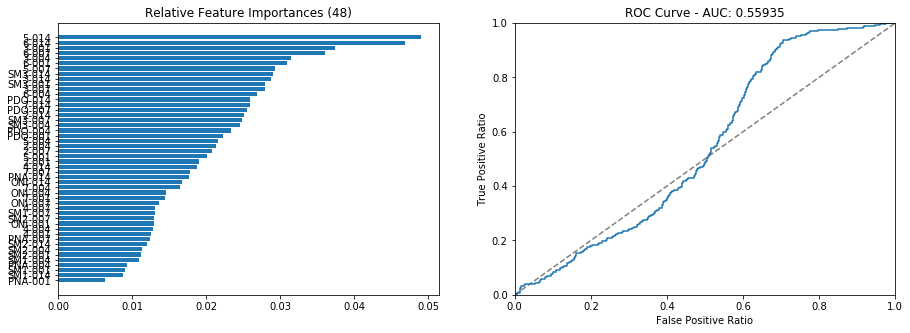

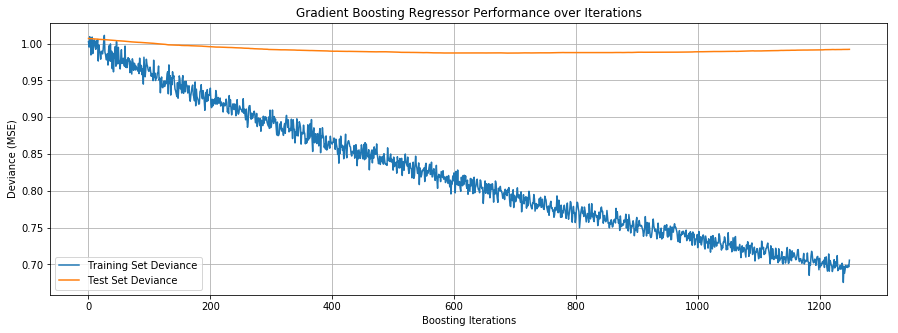

In [142]:
PRECURSOR = 5

spatcov_scores = []
gbr_scores = []

LAGS = list(range(0, 101, 2))

for LAG in LAGS:
    
    print(f"LAG: {LAG}")

    # Labels
    labels = Labels(binary=False)

    # Spatial Covariance Predictor
    features = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR)
    split = TrainTestSplit(features, labels)
    predictor_spatcov = SpatialCovariancePredictor(split)
    print(f"Spatial Covariance:"); predictor_spatcov.scores
    spatcov_scores.append(predictor_spatcov.auc)

    WINDOWS = [1, 4, 7, 14]

    selection = {
        "SM1": [WINDOWS, [0]*len(WINDOWS)],
        "SM2": [WINDOWS, [0]*len(WINDOWS)],
        "SM3": [WINDOWS, [0]*len(WINDOWS)],
        "ONI": [WINDOWS, [0]*len(WINDOWS)],
        "PDO": [WINDOWS, [0]*len(WINDOWS)],
        "PNA": [WINDOWS, [0]*len(WINDOWS)],
    }

    if ERA == 'ERA':
        NINA = 3
        CARIBEAN = 7
        MONSOON = 8
        LAKES = 2
        ICELAND = 6
        PEP = 4
    elif ERA == 'ERA5':
        NINA = 3
        CARIBEAN = 6
        MONSOON = 5
        LAKES = 2
        ICELAND = 7
        PEP = 4 
    elif ERA == 'EC-Earth':
        NINA = 3
        CARIBEAN = 9
        MONSOON = -1
        LAKES = -1
        ICELAND = 5
        PEP = 4

    selection.update({
        str(NINA): [WINDOWS, [0]*len(WINDOWS)],
        str(PEP): [WINDOWS, [0]*len(WINDOWS)],
        str(CARIBEAN): [WINDOWS, [0]*len(WINDOWS)],
        str(LAKES): [WINDOWS, [0]*len(WINDOWS)],
        str(MONSOON): [WINDOWS, [0]*len(WINDOWS)],
        str(ICELAND): [WINDOWS, [0]*len(WINDOWS)],
    })

    # Load Features
    features = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR, selection=selection)

    # Perform Train/Test Split
    split = TrainTestSplit(features, labels, 0)

    # Prediction Pipeline (for Each Fold)
    def predict(year: int, train_X: pd.DataFrame, train_y: pd.DataFrame, test_X: pd.DataFrame, test_y: pd.DataFrame) -> Tuple[GradientBoostingRegressor, np.ndarray]:

        regressor = GradientBoostingRegressor(
            max_depth=4,
            learning_rate=0.001,
            n_estimators=1250,
            max_features='sqrt',
            subsample=0.5)

    #     selector = RFE(regressor, 20, step=1)
    #     selector.fit(train_X, train_y.values.ravel())

    #     regressor = selector.estimator_
    #     predictions = regressor.predict(test_X[test_X.columns[selector.support_]])

        regressor.fit(train_X, train_y.values.ravel())
        predictions = regressor.predict(test_X)

        return regressor, pd.DataFrame(predictions, index=test_y.index)

    # Machine Learning
    predictor = Predictor(split, predict)

    print(f"Gradient Boosting:"); predictor.scores
    gbr_scores.append(predictor.auc)

    print()
    print(stats.wilcoxon(predictor._scores['auc'], predictor_spatcov._scores['auc']))
    print(stats.ttest_rel(predictor._scores['auc'], predictor_spatcov._scores['auc']))

    # Plot Importances & ROC Curve
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.subplot(121);
    importances = predictor.plot_importances()
    plt.subplot(122);
    predictor.plot_roc()
    plt.show()

    # Deviance Curve
    predictor.plot_deviance()
    plt.show()

    # auc = []
    # for i in range(10):
    #     predictor = Predictor(split, predict)
    #     auc.append(predictor.auc)
    #     print(f"\r[{i+1:2d}] AUC: {np.mean(auc):3.3f} ± {np.std(auc):3.3f}", end="")

# Performance over Lags

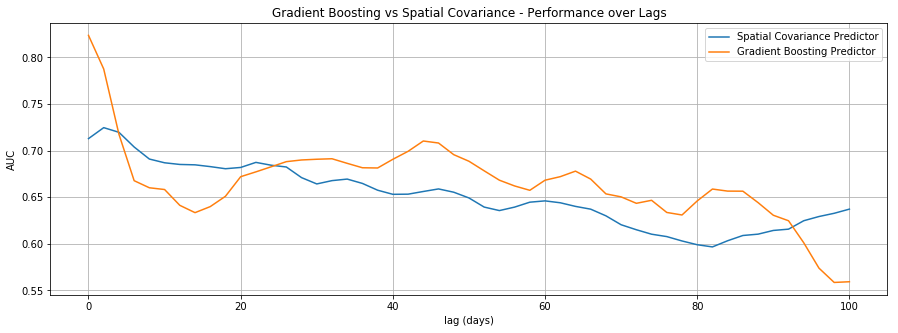

In [143]:
plt.title("Gradient Boosting vs Spatial Covariance - Performance over Lags")
plt.plot(LAGS, spatcov_scores, label="Spatial Covariance Predictor")
plt.plot(LAGS, gbr_scores, label="Gradient Boosting Predictor")
plt.xlabel("lag (days)")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()

# Partial Dependence Plots

In [119]:
LEGEND = {
    'ONI': "El Niño 3.4 Index (ONI)",
    'PDO': "Pacific Decedal Oscilation (PDO)",
    'PNA': "Pacific North American Oscilation (PNA)",
    'SM1': "Soil Moisture (Level 1)",
    'SM2': "Soil Moisture (Level 2)",
    'SM3': "Soil Moisture (Level 3)",
    '3': "La Niña",
    '6': "Caribbean",
    '5': "Monsoon",
    '2': "Great Lakes",
    '7': "North Atlantic",
    '4': "Pacific Extreme Pattern (PEP)"
}

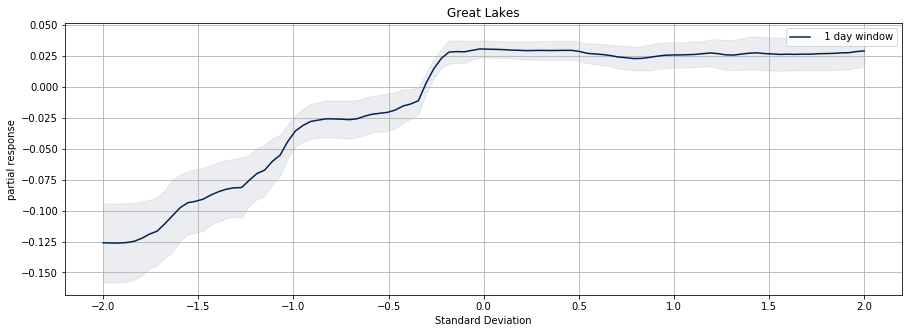

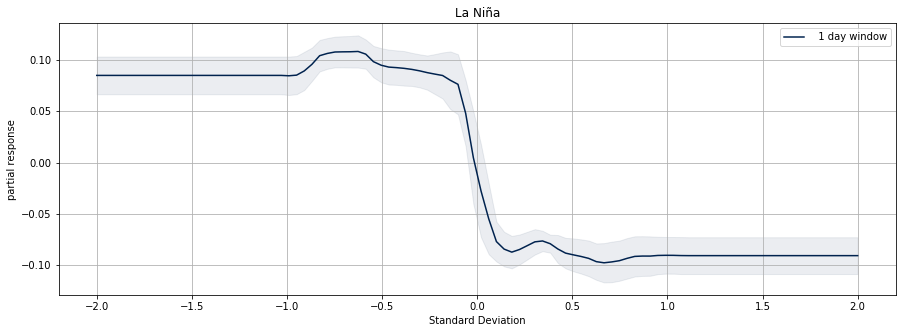

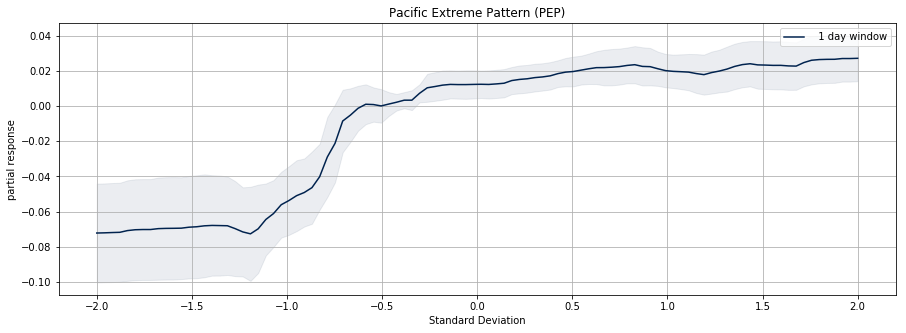

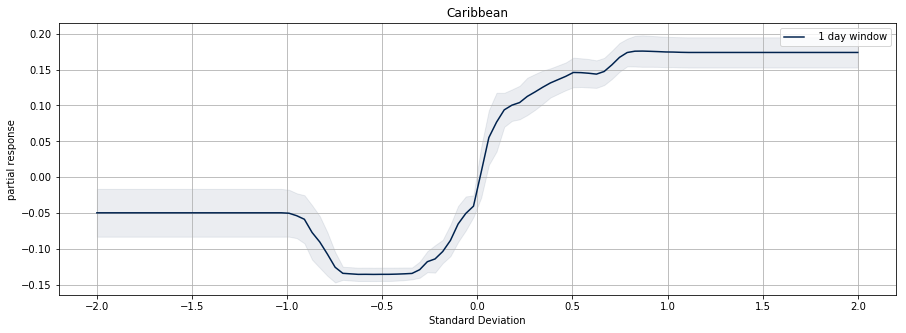

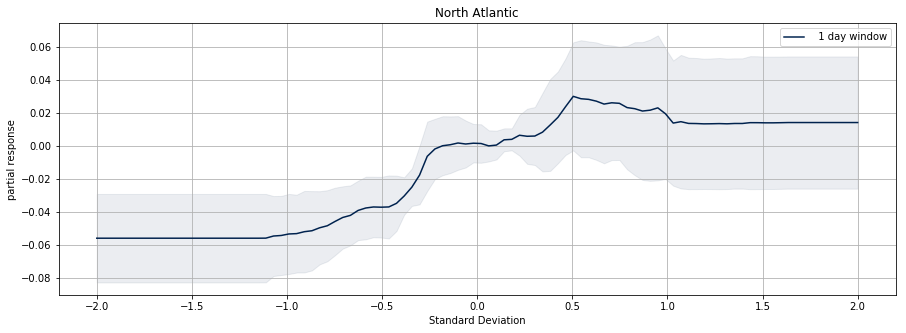

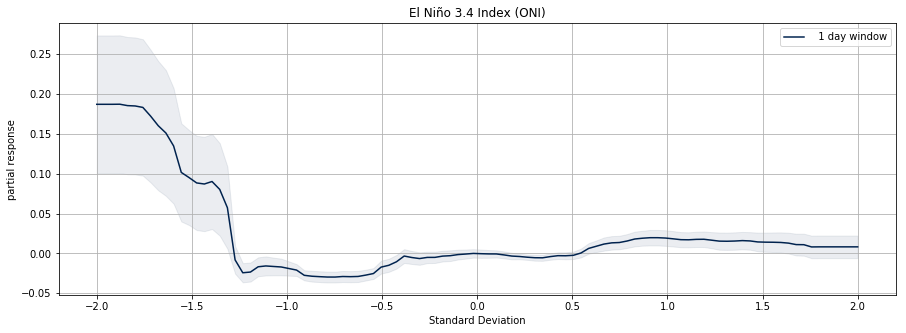

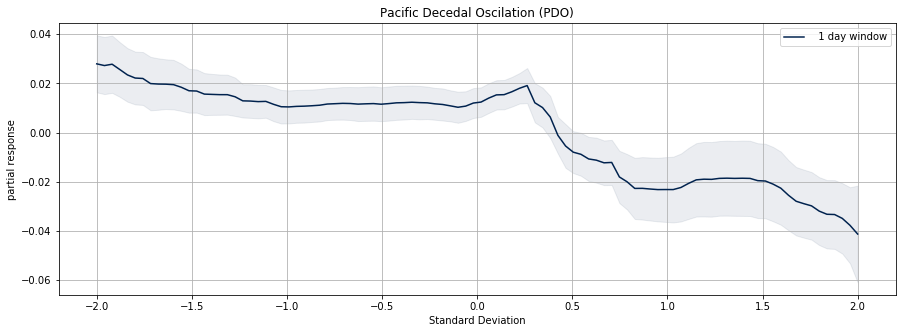

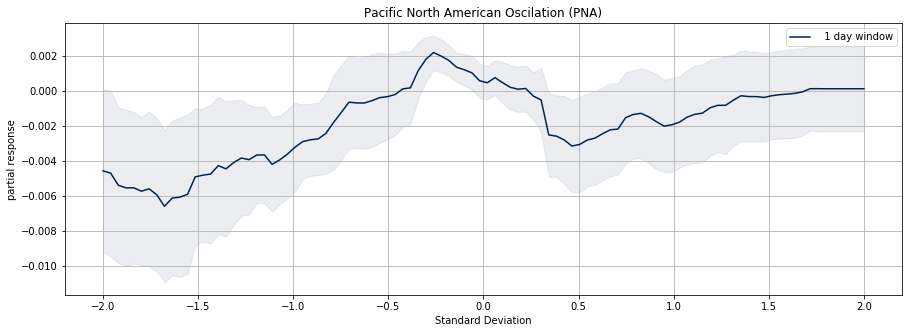

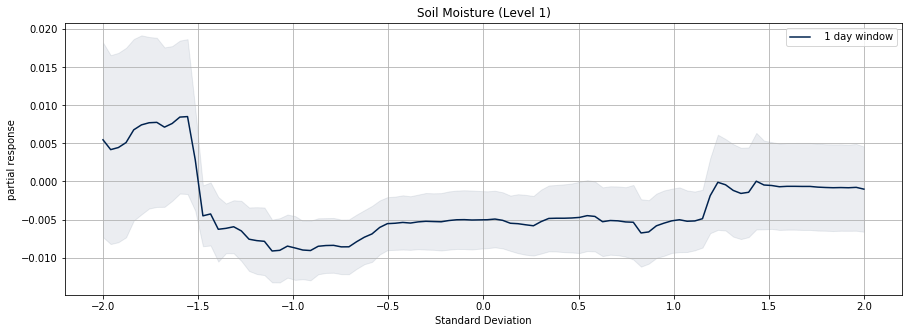

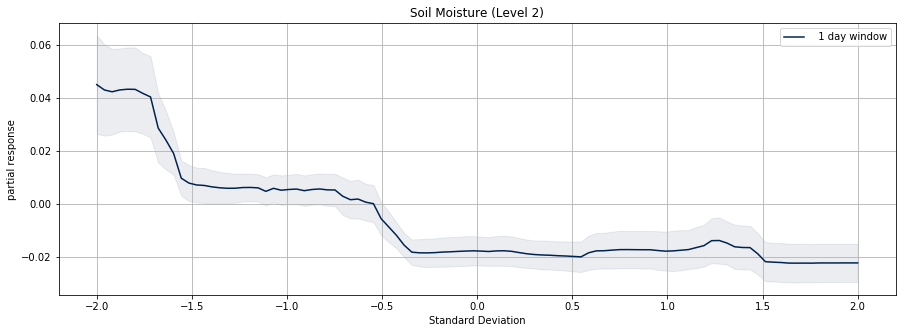

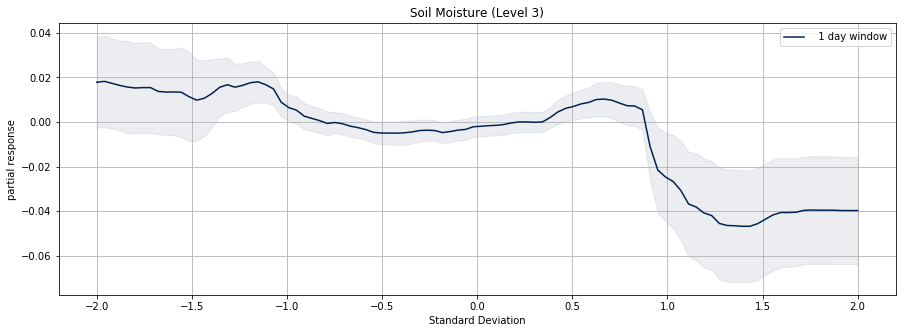

In [122]:
all_features = set()
[all_features.update(list(features.get(fold).columns)) for fold in features.years]


for i, target_feature in enumerate(sorted(all_features), 1):
    x = np.linspace(-2, 2, 100)
    y = []
    for fold in features.years:
        feature_indices = list(features.get(fold).columns)
        
        if target_feature in feature_indices:
            index = feature_indices.index(target_feature)
            y.append(partial_dependence.partial_dependence(predictor._regressors[fold], [index], x)[0])
            
    color = cm.cividis(float((i-1)%len(WINDOWS))/len(WINDOWS))
    feature, window = [s for s in target_feature.split('-')]
    window = int(window)
    
    y_mean = np.mean(y, 0).ravel()
    y_std = np.std(y, 0).ravel()
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=0.08)
    plt.plot(x, y_mean, color=color, label=f"{window:3d} day window")
    
    
    if not (i % len(WINDOWS)):
        plt.title(f"{LEGEND[feature]}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("partial response")
        plt.grid()
        plt.legend()
        plt.show()

# Visual Analysis

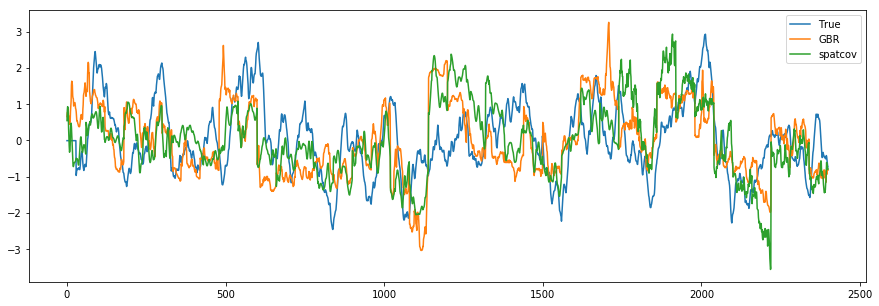

In [51]:
def normalize(values):
    return (values - values.mean()) / values.std()

y_true = labels.get().rolling(30).mean().values.ravel()
y_true[np.isnan(y_true)] = 0

plt.plot(normalize(y_true), label="True")
plt.plot(normalize(predictor.predictions.values.ravel()), label='GBR')
plt.plot(normalize(predictor_spatcov.predictions.values.ravel()), label='spatcov')
plt.legend()
plt.show()

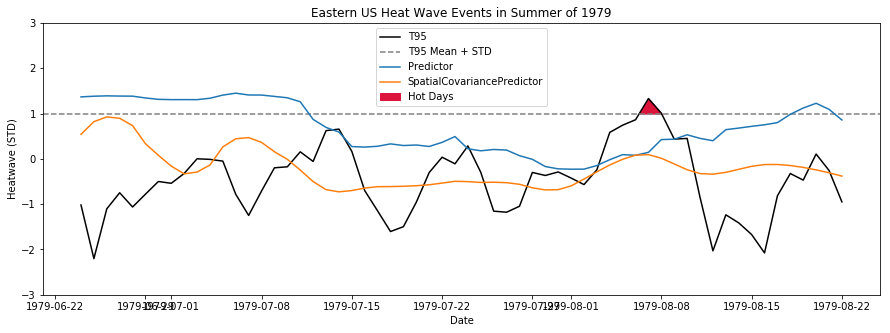

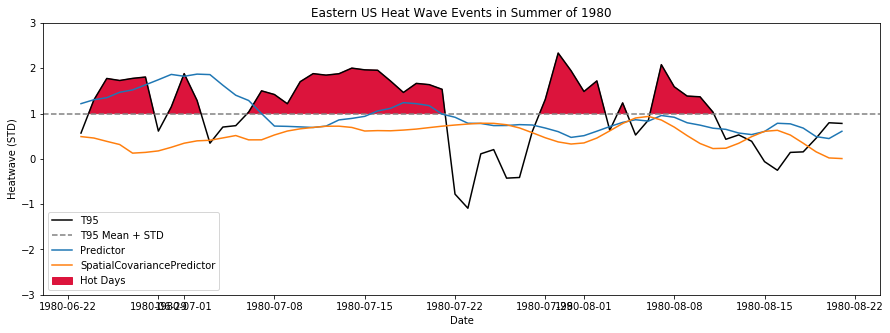

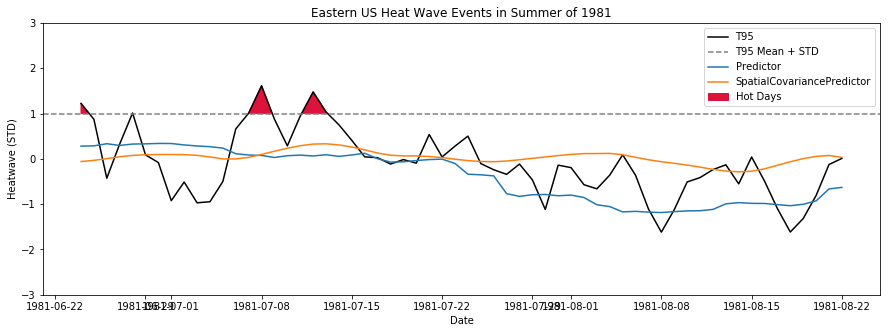

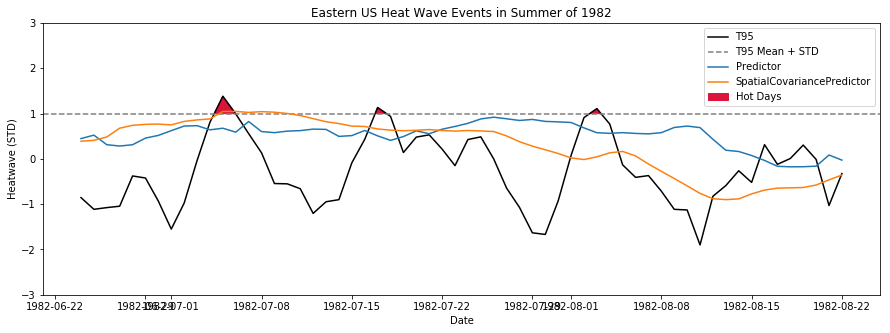

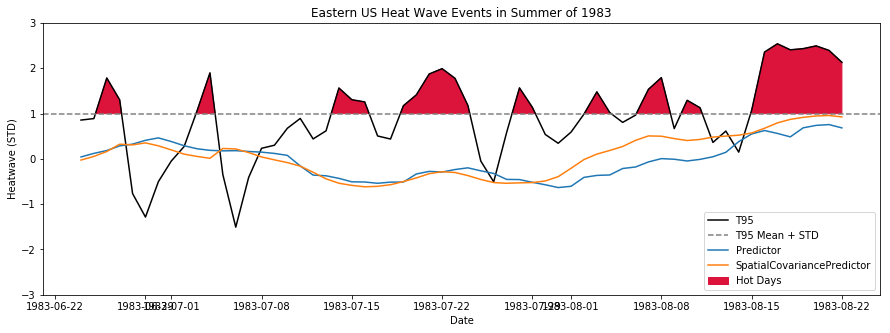

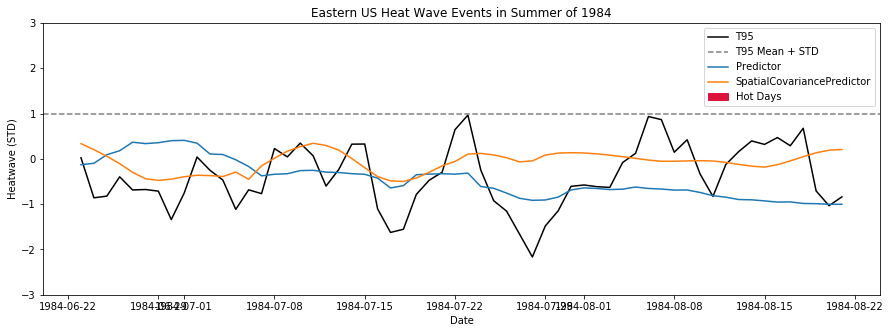

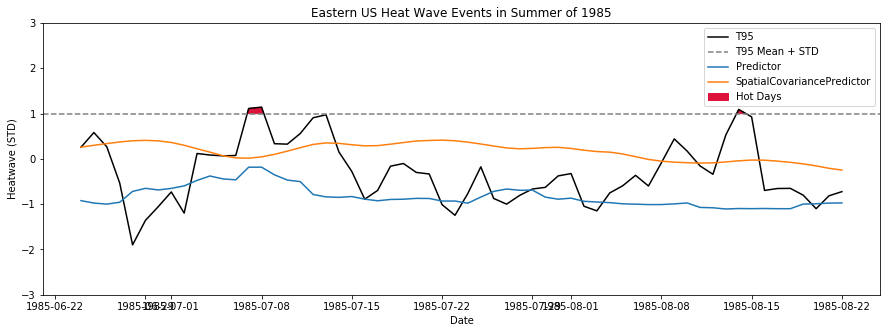

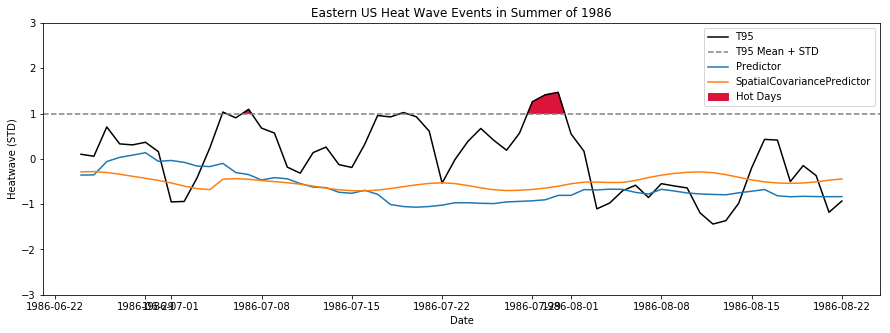

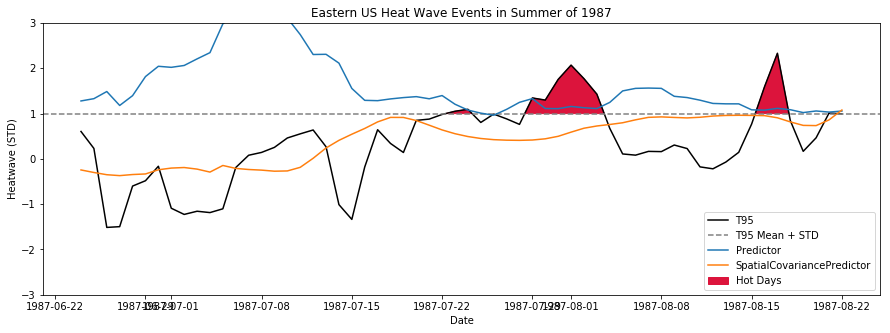

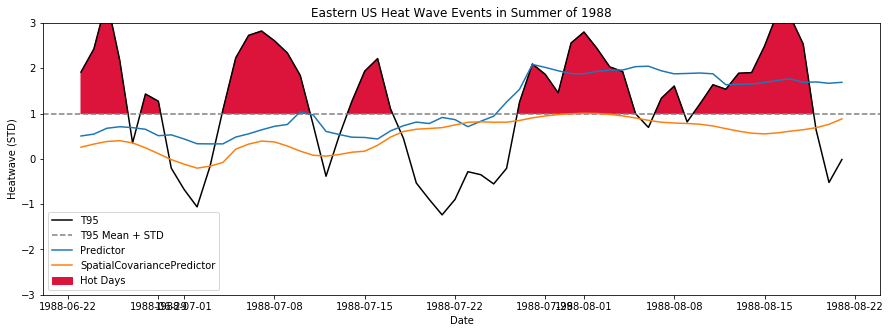

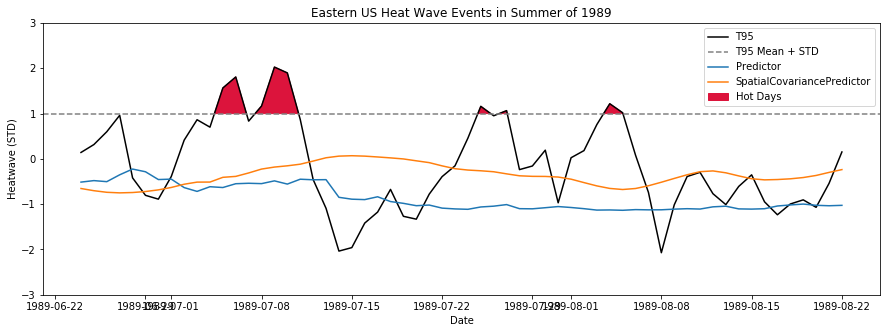

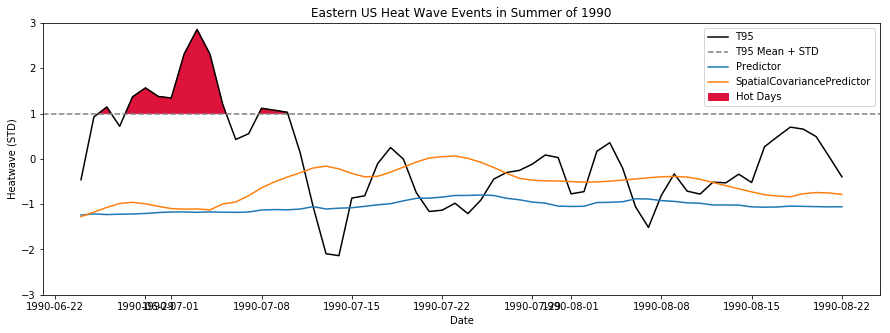

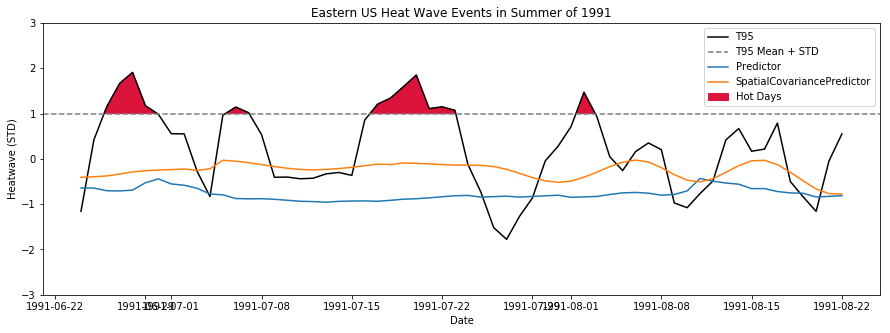

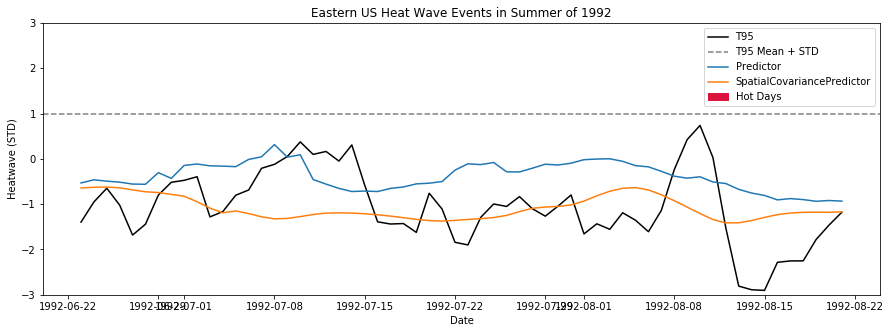

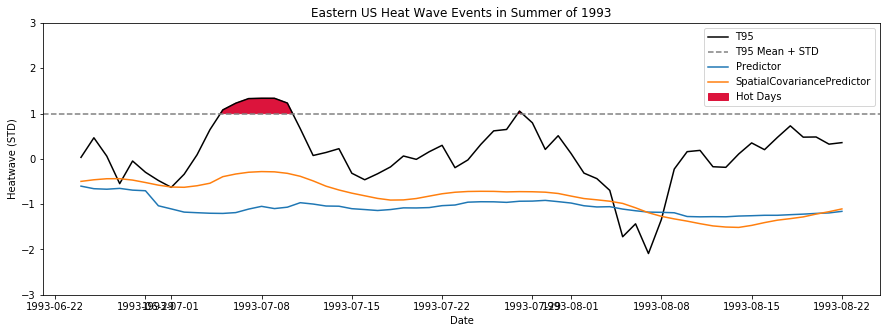

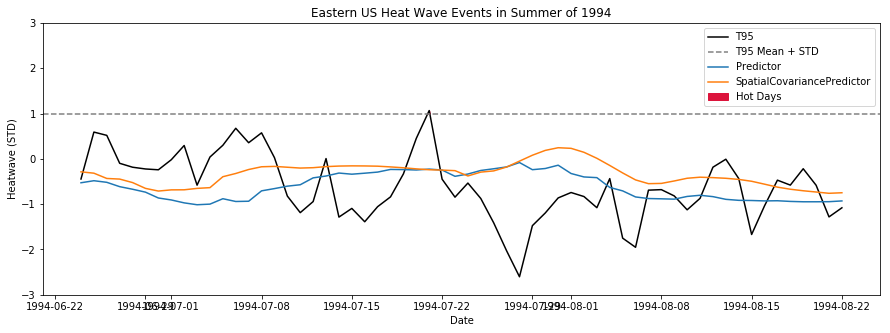

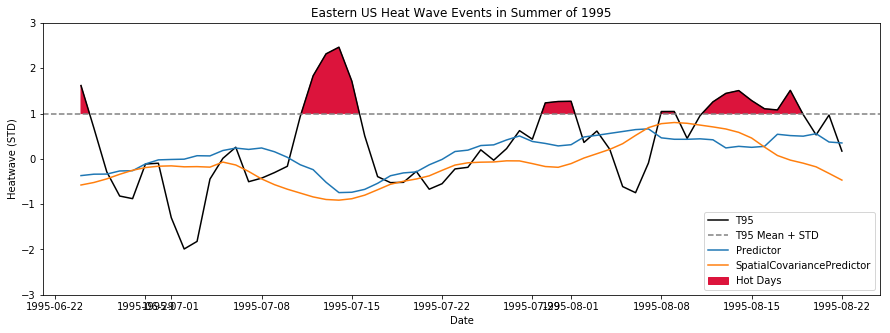

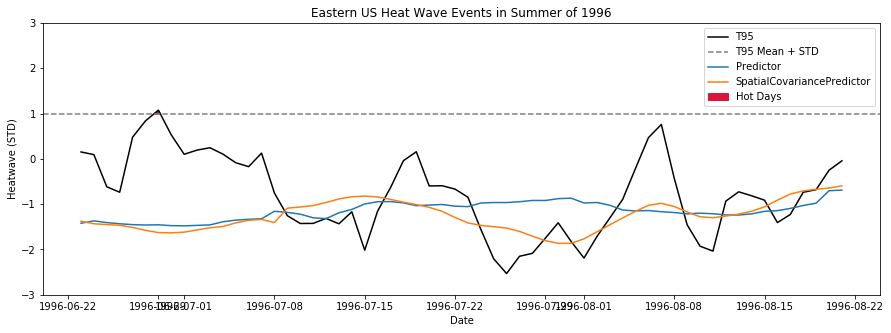

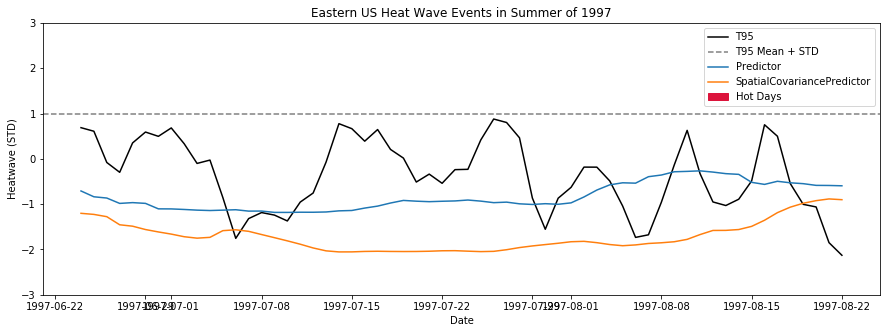

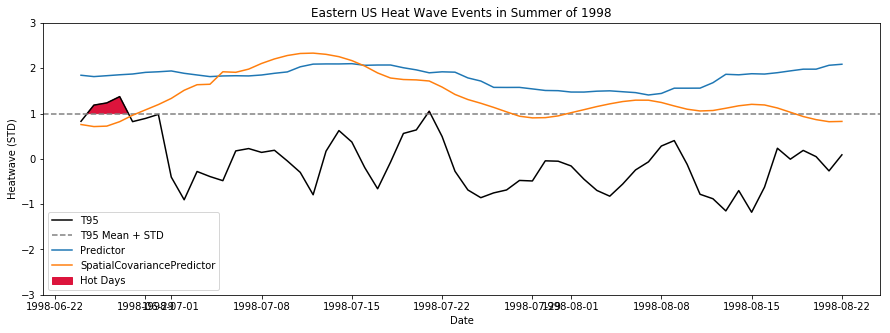

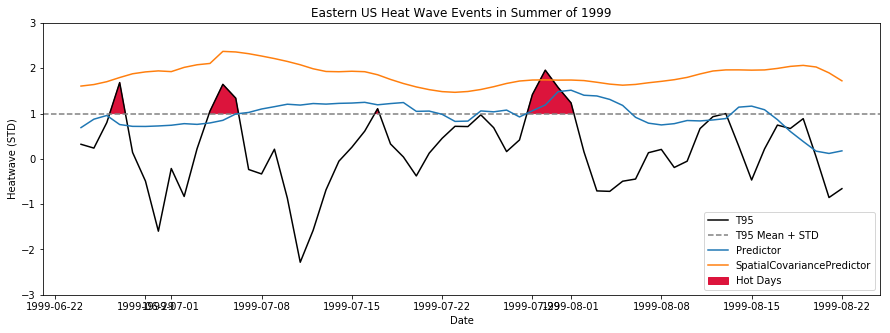

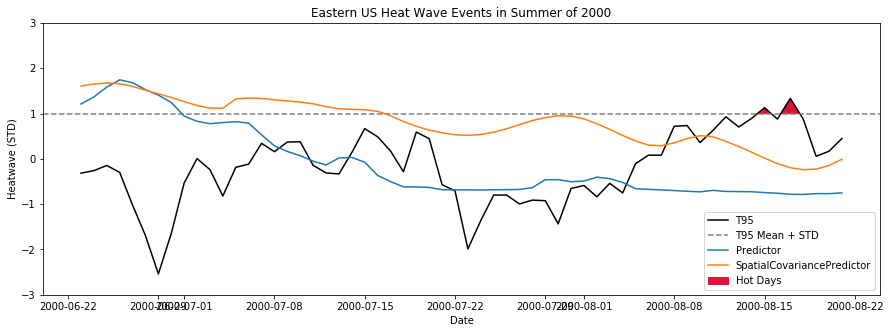

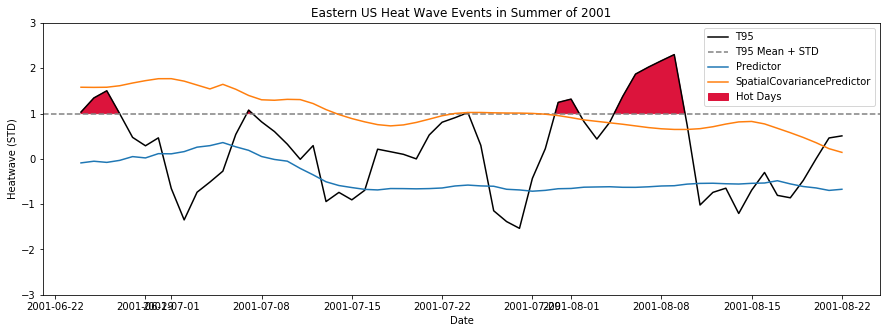

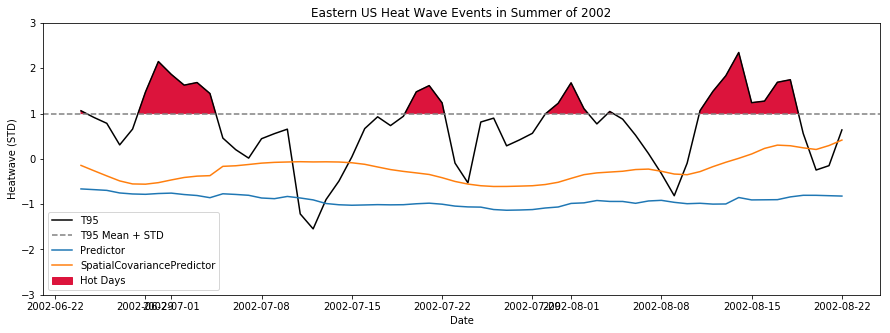

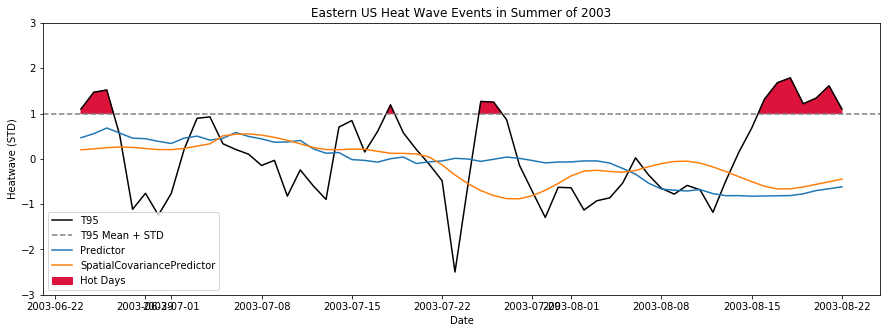

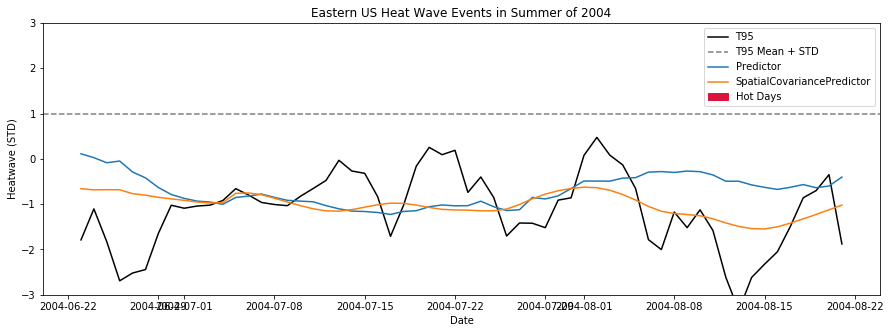

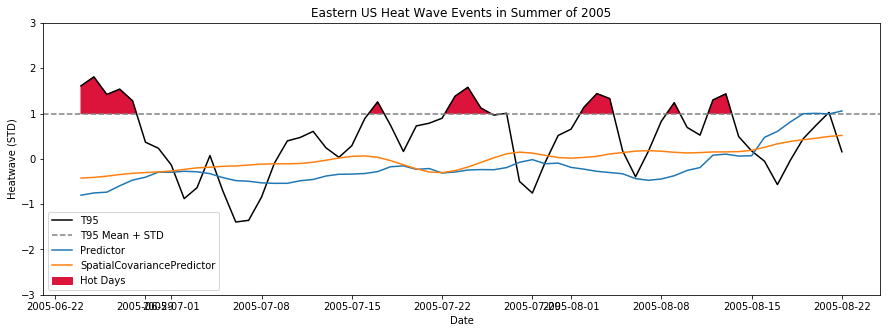

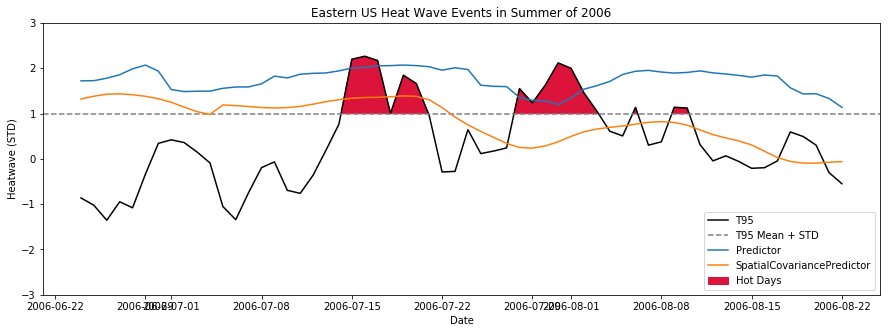

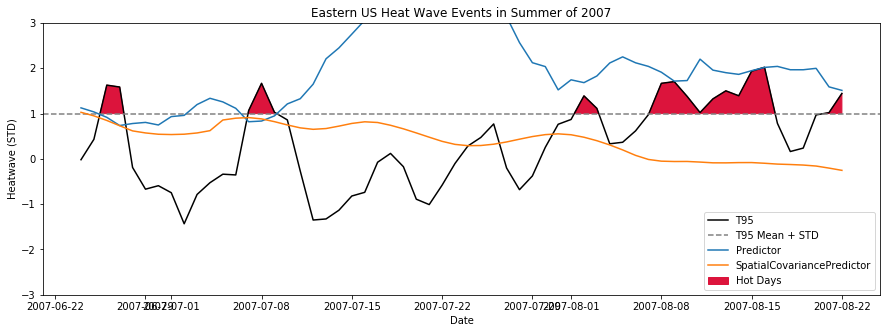

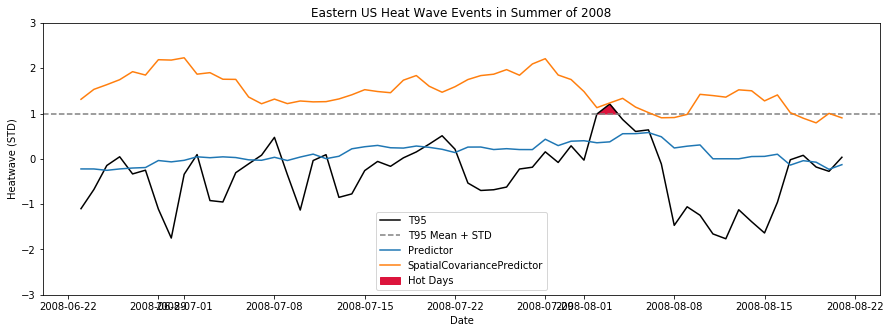

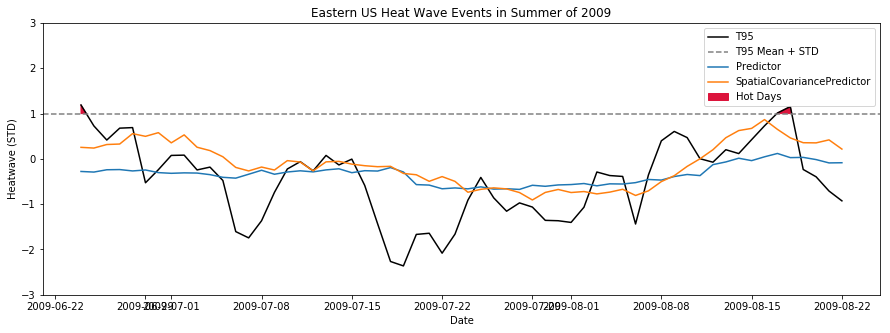

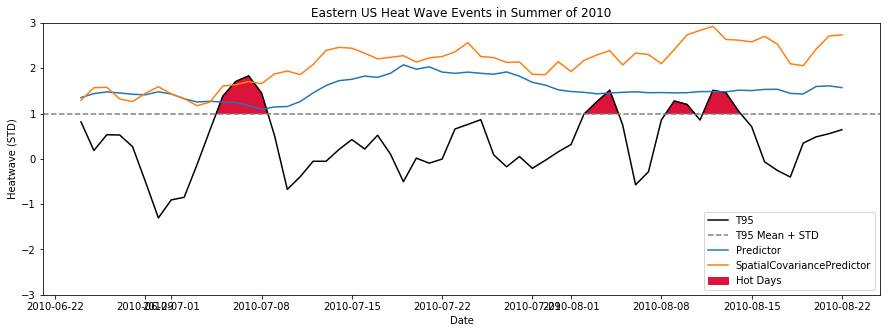

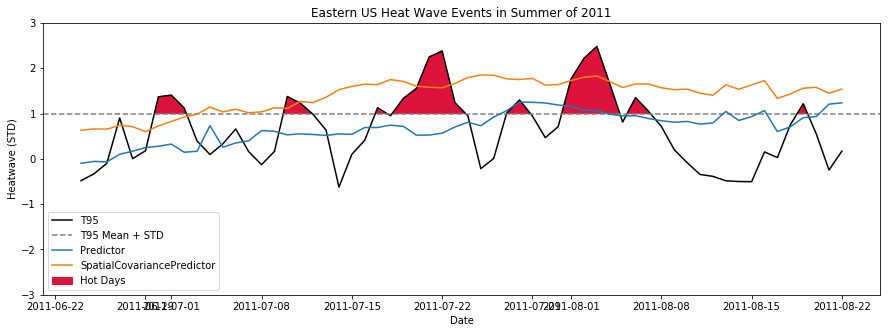

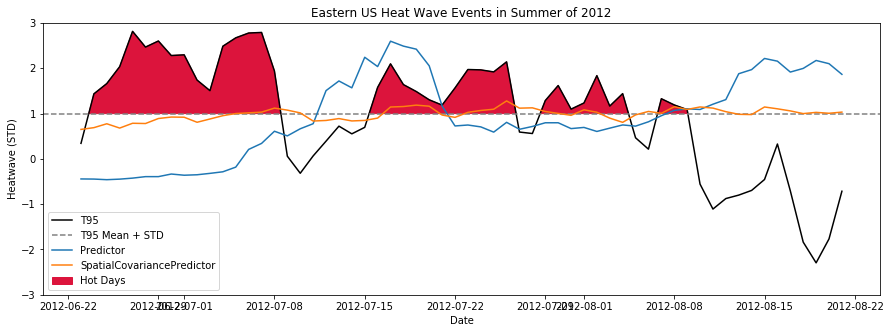

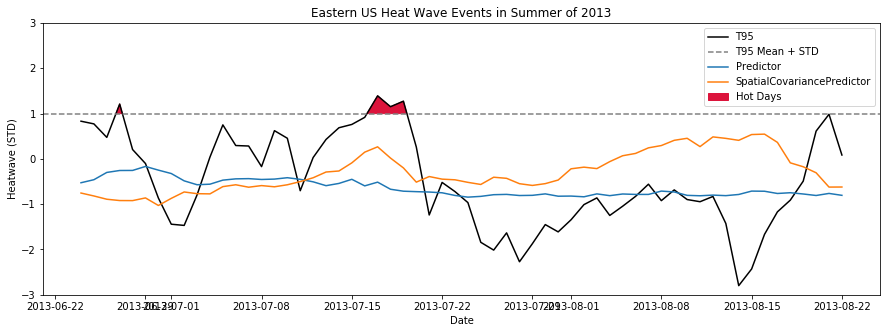

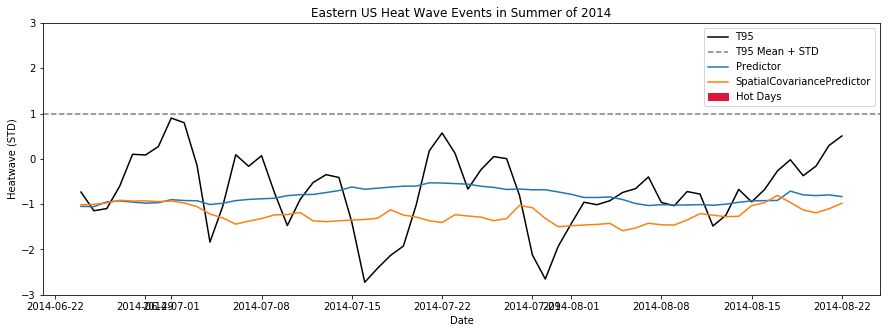

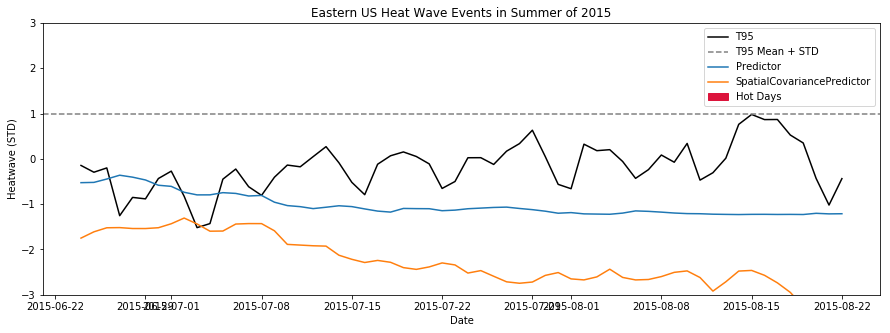

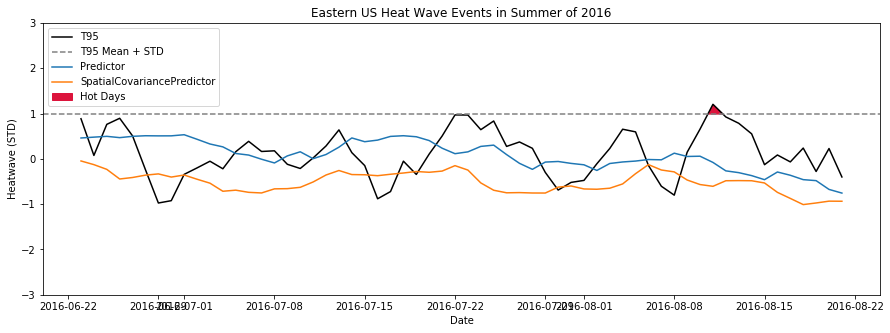

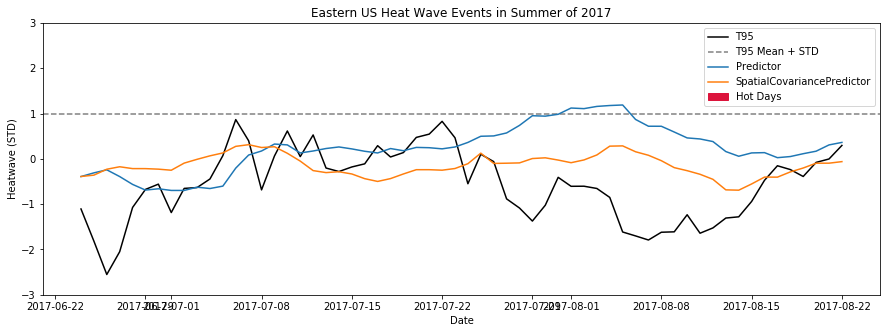

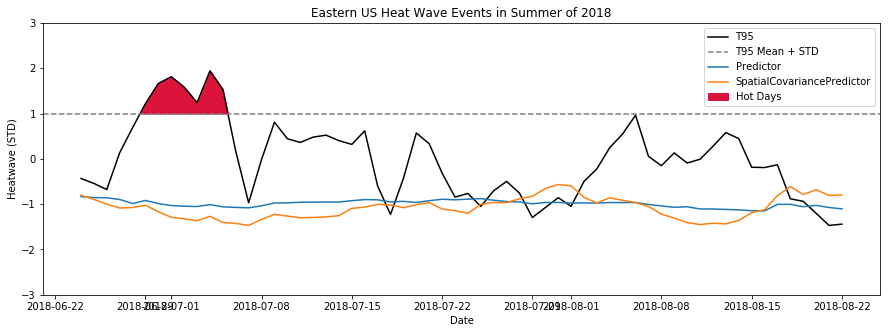

In [63]:
labels = Labels()

for YEAR in labels.years:
    labels.plot(YEAR)
    predictor.plot(YEAR)
    predictor_spatcov.plot(YEAR)
    plt.legend()
    plt.show()